# Распознавание токсичных комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Необходимо обучить модель классифицировать комментарии на позитивные и негативные.\
Есть в наличии набор данных с разметкой о токсичности правок. В файле `toxic_comments.csv` столбец *text* содержит комментарий, а *toxic* — целевой признак.

Требуется построить модель со значением метрики качества *F1* не меньше 0.75.

## Загрузка и анализ

In [1]:
!pip install wordcloud -q
!pip install transformers -q
!pip install termcolor -q
!pip install catboost -q
!pip install spacy -q
!spacy download en_core_web_sm -q
!pip install imblearn -q

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import torch
import transformers
import numpy as np
from tqdm import notebook
from wordcloud import WordCloud
import spacy
from math import ceil
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import re
import matplotlib.pyplot as plt
from termcolor import colored

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [4]:
constant = 12345  # для random_state

In [5]:
try:
    data = pd.read_csv('../../21 nlp/project/toxic_comments.csv')
except:
    try:
        data = pd.read_csv('/datasets/toxic_comments.csv')
    except:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [6]:
data.head(3)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [8]:
data.duplicated().sum() # проверка на наличие дубликатов

0

In [9]:
data['toxic'].mean() # доля класса 1

0.10161213369158527

Сильный дисбаланс: 1 к 9.

## Кодирование

### Стоп-слова, лемматизация, токенизация, разбиение

In [10]:
def preprocessing(x):
    '''удаляет спец. и одиночные символы, цифры, дубли, стоп-слова; лемматизация; на входе/выходе string;
       должны существовать nlp(spacy.load) и stopwords'''
    
    doc = re.sub(r'\W|_', ' ', x)                                     # remove all the special characters
    doc = re.sub(r'\d', ' ', doc)                                     # remove all numbers
    doc = re.sub(r'\s+[a-zA-Z]\s+([a-zA-Z]\s+)*', ' ', doc)           # remove all single characters
    doc = re.sub(r'\s+([a-zA-Z])\1+\s+(([a-zA-Z])\1+\s+)*', ' ', doc) # remove all duplicate characters
    doc = re.sub(r'^[a-zA-Z]\s+|\s+[a-zA-Z]$', ' ', doc)              # remove single characters from the start and at the end
    doc = re.sub(r'\s+', ' ', doc)                                    # substituting multiple spaces with single space
    doc = doc.lower()                                                 # converting to Lowercase
    doc = ' '.join([word for word in doc.split() if word not in stopwords]) # delete stopwords
    return ' '.join([token.lemma_ for token in nlp(doc)])             # lemmatization

In [11]:
# создание структуры данных для лемматизации
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# множество стоп-слов для удаления таковых из текста
stopwords = nlp.Defaults.stop_words|{'br', 'mr', 'mrs', 'miss', 'ms', 'bozxphd', 'â', 'ª', 'ªâ', 'âª'}

In [12]:
%%time
text_lem_clear = data['text'].apply(lambda x: preprocessing(x))
text_lem_clear.head()

CPU times: total: 7min 32s
Wall time: 7min 32s


0    explanation edit username hardcore metallica f...
1    aww match background colour seemingly stuck th...
2    hey man try edit war guy constantly remove rel...
3    real suggestion improvement wonder section sta...
4                        sir hero chance remember page
Name: text, dtype: object

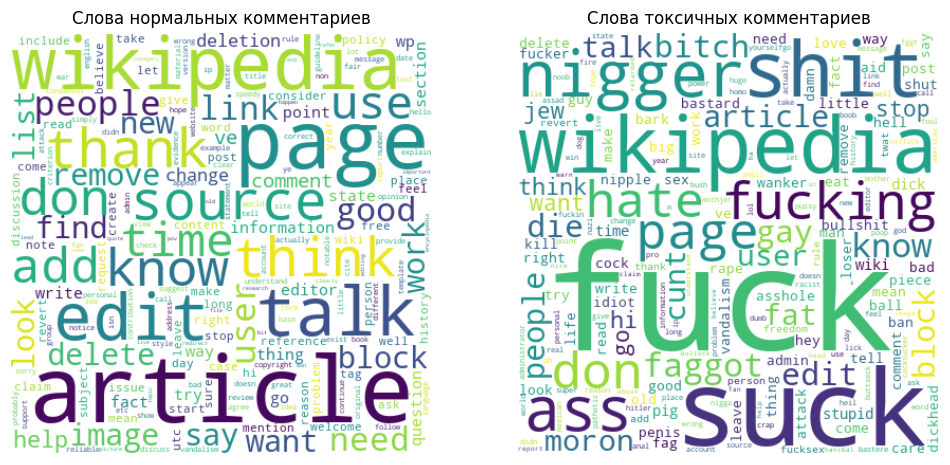

In [17]:
# облака из слов, которые составляют позитивные и неготивные комментарии
text_positive = ' '.join(text_lem_clear[data['toxic']==0].tolist())
text_toxic    = ' '.join(text_lem_clear[data['toxic']==1].tolist())

wordcloud_positive = WordCloud(background_color="white", width=400, height=400, collocations=False).generate(text_positive)
wordcloud_toxic    = WordCloud(background_color="white", width=400, height=400, collocations=False).generate(text_toxic)

f,ax = plt.subplots(1,2, figsize=(12,7))
ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[1].imshow(wordcloud_toxic,    interpolation='bilinear')
ax[0].set_title('Слова нормальных комментариев'); ax[1].set_title('Слова токсичных комментариев')
ax[0].axis("off"); ax[1].axis("off"); plt.show()

In [18]:
def split(X, Y):
    '''разбивает датасет на обучающую, валидационную, тестовую выборки (0.6/0.2/0.2); на входе признаки и целевой признак'''
    X_train, X_valid_test, Y_train, Y_valid_test = train_test_split(X, Y, stratify = Y,
                                                                    random_state = constant, test_size = 0.4)
    X_valid, X_test, Y_valid, Y_test             = train_test_split(X_valid_test, Y_valid_test, stratify = Y_valid_test,
                                                                    random_state = constant, test_size = 0.5)

    print('Размерности выборок:')
    print(f'X_train_ = {X_train.shape}   Y_train = {Y_train.shape}')
    print(f'X_valid_ = {X_valid.shape}   Y_valid = {Y_valid.shape}')
    print(f'X_test_  = {X_test.shape}    Y_test  = {Y_test.shape}')

    return X_train, X_valid, X_test, Y_train, Y_valid, Y_test

In [19]:
# разбиваем датасет (лемматизированный, очищенный) на подвыборки для ML - 0.6/0.2/0.2
X_train_lem_clear, X_valid_lem_clear, X_test_lem_clear, Y_train, Y_valid, Y_test = split(text_lem_clear, data['toxic'])

Размерности выборок:
X_train_ = (95575,)   Y_train = (95575,)
X_valid_ = (31858,)   Y_valid = (31858,)
X_test_  = (31859,)    Y_test  = (31859,)


### TF-IDF

In [20]:
# TF-IDF-токенизация выборок и уменьшение занимаемой памяти (тип c 'float64' на 'float32')
count_tf_idf = TfidfVectorizer(dtype='float32')
count_tf_idf.fit(X_train_lem_clear)

X_train_tfidf = count_tf_idf.transform(X_train_lem_clear)
X_valid_tfidf = count_tf_idf.transform(X_valid_lem_clear)
X_test_tfidf  = count_tf_idf.transform(X_test_lem_clear)

# проверка размерности
print(X_train_tfidf.shape)
print(X_valid_tfidf.shape)
print(X_test_tfidf.shape)

C:\Anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\feature_extraction\text.py:2077: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float32 'dtype' will be converted to np.float64.
  warnings.warn(


(95575, 116435)
(31858, 116435)
(31859, 116435)


### Bert

Кодирование стандартным BERT исходного текста (нелемматизированного, неочищенного).

In [21]:
# Загрузка предобученной модели/токенизатора
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model     = transformers.BertModel.from_pretrained('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
%%time
tokenized = data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

CPU times: total: 3min 32s
Wall time: 3min 32s


In [23]:
max_len = tokenized.apply(lambda x: len(x)).max()
max_len

512

In [24]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
padded

array([[  101,  7526,  2339, ...,     0,     0,     0],
       [  101,  1040,  1005, ...,     0,     0,     0],
       [  101,  4931,  2158, ...,     0,     0,     0],
       ...,
       [  101, 13183,  6290, ...,     0,     0,     0],
       [  101,  1998,  2009, ...,     0,     0,     0],
       [  101,  1000,  1998, ...,     0,     0,     0]])

In [25]:
padded.shape

(159292, 512)

In [26]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(159292, 512)

In [27]:
def get_bert_embeddings():
    '''на основе западдированного множества (padded), attention_mask и BERT-модели возвращает эмбеддинги'''
    # ячейка для работы на GPU
    batch_size = 100
    embeddings = []

    for i in notebook.tqdm(range(ceil(padded.shape[0] / batch_size))):

        # Преобразуем данные в формат тензоров
        batch                = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

        # Чтобы получить эмбеддинги для батча, передадим модели данные и маску; градиенты не вычисляем
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        # Из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов.
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

    # Соберём все эмбеддинги в матрицу признаков
    return np.concatenate(embeddings)

In [ ]:
features = get_bert_embeddings() # рассчитываем BERT-эмбеддинги

In [28]:
# эмбеддинги, полученные в ячейке выше с помощью GPU; сохранены на ПК для локальной работы на CPU
# запускается либо ячейка выше, либо данная

# features = pd.read_csv('../../21 nlp/project/toxic_comments_embeddings.csv')

# ссылка на файл в облаке (1.3 ГБ): https://drive.google.com/file/d/10sp5vkkFY6rVmxA5LLAE5XH6kgCPSlCX/view?usp=drive_link

In [29]:
features

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.250975,0.050542,-0.002417,-0.232462,-0.306949,-0.372467,0.556584,0.522573,0.218741,-0.453635,...,0.194120,-0.091435,0.003685,-0.201188,0.569002,0.093805,-0.121612,-0.095249,0.334349,0.479536
1,-0.338791,-0.276552,0.313010,-0.204264,0.019006,-0.555100,0.629416,0.154863,0.258903,-0.475852,...,0.274516,-0.283099,0.174904,-0.513817,0.472171,0.079125,0.184341,-0.179844,1.058293,0.795584
2,0.424249,0.188240,-0.259348,-0.114313,-0.638328,-0.475204,0.168303,0.743385,-0.018781,-0.431729,...,-0.200267,-0.164308,0.367090,-0.392819,0.067134,0.613549,-0.120030,0.147486,0.645279,0.796947
3,0.306886,0.219930,0.389265,-0.074342,0.092669,-0.645452,-0.051676,0.581139,-0.116402,-0.237622,...,0.175040,-0.094764,0.087812,-0.238126,0.369479,0.043336,-0.566773,-0.186496,0.336376,0.731668
4,0.045146,-0.010957,0.037360,-0.053779,-0.064093,-0.419963,0.308800,0.812772,-0.348816,0.075106,...,-0.053372,-0.416634,0.118101,-0.440070,0.428577,0.148663,-0.355484,-0.327330,0.339055,0.600750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159287,0.283147,0.163041,-0.205194,-0.163754,0.082115,-0.330665,0.246821,0.235963,0.173287,-0.185513,...,0.152632,-0.178766,-0.155665,-0.252335,-0.118370,0.341087,-0.013640,-0.095497,0.619086,0.508700
159288,0.013351,0.250915,0.109796,-0.085546,-0.258973,-0.433132,0.700256,0.719394,-0.096991,-0.497617,...,0.011592,-0.156390,0.081115,-0.309774,0.543967,0.211181,-0.182518,-0.231150,0.505609,0.569340
159289,0.203689,0.071679,-0.117422,0.142101,-0.412787,-0.146687,0.407212,1.117566,0.064179,-0.516541,...,-0.265362,-0.069738,-0.182752,-0.052053,-0.045013,-0.236323,-0.478984,-0.499757,0.726302,0.570208
159290,0.012694,-0.099803,0.084754,0.113606,-0.349570,-0.451207,0.162055,0.501425,-0.159921,-0.115498,...,-0.227353,-0.298888,-0.128746,0.028136,0.119898,0.306994,-0.103744,-0.186145,0.314823,0.563951


In [30]:
features = features.astype('float32') # перевод признаков из 'float64' во 'float32'

In [31]:
# разбиваем датасет на подвыборки для ML - 0.6/0.2/0.2
X_train_bert, X_valid_bert, X_test_bert, Y_train, Y_valid, Y_test = split(features, data['toxic'])

Размерности выборок:
X_train_ = (95575, 768)   Y_train = (95575,)
X_valid_ = (31858, 768)   Y_valid = (31858,)
X_test_  = (31859, 768)    Y_test  = (31859,)


### Bert (toxic)

In [32]:
# Загрузка предобученной модели/токенизатора
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')
model     = transformers.BertModel.from_pretrained('unitary/toxic-bert').to(device)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
%%time
tokenized = data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

CPU times: total: 3min 32s
Wall time: 3min 32s


In [34]:
max_len = tokenized.apply(lambda x: len(x)).max()
max_len

512

In [35]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
padded

array([[  101,  7526,  2339, ...,     0,     0,     0],
       [  101,  1040,  1005, ...,     0,     0,     0],
       [  101,  4931,  2158, ...,     0,     0,     0],
       ...,
       [  101, 13183,  6290, ...,     0,     0,     0],
       [  101,  1998,  2009, ...,     0,     0,     0],
       [  101,  1000,  1998, ...,     0,     0,     0]])

In [36]:
padded.shape

(159292, 512)

In [37]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(159292, 512)

In [ ]:
features = get_bert_embeddings()              # рассчитываем BERT-эмбеддинги

In [38]:
# эмбеддинги, полученные в ячейке выше с помощью GPU; сохранены на ПК для локальной работы на CPU
# запускается либо ячейка выше, либо данная

# features = pd.read_csv('../../21 nlp/project/features_bert_toxic.csv')

# ссылка на файл в облаке (1.3 ГБ): https://drive.google.com/file/d/1JKNSeTS8U5JHZYz2-sp7HUbcKd3iBWpU/view?usp=sharing

In [39]:
features = features.astype('float32') # перевод признаков из 'float64' во 'float32'

In [40]:
# разбиваем датасет на подвыборки для ML - 0.6/0.2/0.2
X_train_bert_toxic, X_valid_bert_toxic, X_test_bert_toxic, Y_train, Y_valid, Y_test = split(features, data['toxic'])

Размерности выборок:
X_train_ = (95575, 768)   Y_train = (95575,)
X_valid_ = (31858, 768)   Y_valid = (31858,)
X_test_  = (31859, 768)    Y_test  = (31859,)


## Обучение

### LogisticRegression

#### TF-IDF

In [41]:
def lr(X_train, Y_train, X_valid, Y_valid, solver='lbfgs', class_weight=None):
    '''расчёт f1 с помощью LogisticRegression'''
    model = LogisticRegression(random_state = constant, max_iter=1000, solver=solver, class_weight=class_weight)
    model.fit(X_train, Y_train)
    return f1_score(Y_valid, model.predict(X_valid)).round(4)

In [42]:
%%time
# расчёт f1 при различных solver
for s in ('lbfgs', 'liblinear'):
    f1 = lr(X_train_tfidf, Y_train, X_valid_tfidf, Y_valid, solver=s)
    print(f'f1 = {f1} при solver = {s}')

f1 = 0.7328 при solver = lbfgs
f1 = 0.7312 при solver = liblinear
CPU times: total: 1.89 s
Wall time: 1.79 s


'lbfgs' даёт более высокий результат.

##### class_weight  'balanced'

In [43]:
print(f"f1 = {lr(X_train_tfidf, Y_train, X_valid_tfidf, Y_valid, class_weight='balanced')}")

f1 = 0.758


##### upsampling

In [44]:
oversample = SMOTE(random_state=constant)
X_train_tfidf_up, Y_train_up = oversample.fit_resample(X_train_tfidf, Y_train)
X_train_tfidf_up.shape, Y_train_up.shape                                       # проверка размерности

((171726, 116435), (171726,))

In [45]:
Y_train_up.mean() # баланс классов

0.5

In [47]:
print(f"f1 = {lr(X_train_tfidf_up, Y_train_up, X_valid_tfidf, Y_valid)}")

f1 = 0.6808


##### downsampling

In [48]:
undersample = RandomUnderSampler(random_state=constant)
X_train_tfidf_down, Y_train_down = undersample.fit_resample(X_train_tfidf, Y_train)
X_train_tfidf_down.shape, Y_train_down.shape                                        # проверка размерности

((19424, 116435), (19424,))

In [49]:
Y_train_down.mean() # баланс классов

0.5

In [50]:
print(f"f1 = {lr(X_train_tfidf_down, Y_train_down, X_valid_tfidf, Y_valid)}")

f1 = 0.713


##### threshold

Пробуем варьировать порог при сбалансированном весе классов.

In [51]:
%%time
model = LogisticRegression(random_state = constant, max_iter=1000, class_weight = 'balanced')
model.fit(X_train_tfidf, Y_train)
probability = model.predict_proba(X_valid_tfidf)[:,1]

CPU times: total: 1.05 s
Wall time: 975 ms


In [52]:
def threshold(probability):
    '''определяет лучший f1 в зависимости от порога'''
    df = pd.DataFrame(columns=['f1'])
    for thr in np.arange(0,1.001,0.01):
        prediction = (probability>thr).astype('int')
        df = pd.concat([df, pd.DataFrame(f1_score(Y_valid, prediction).round(4), [thr], ['f1'])])

    df.plot(grid=True, figsize=(5,3), xlabel='threshold', title = 'Распределение f1 в зависимости от threshold'); plt.show()
    print(f'f1_max = {df.max().item()} при threshold = {df.idxmax().item()}')

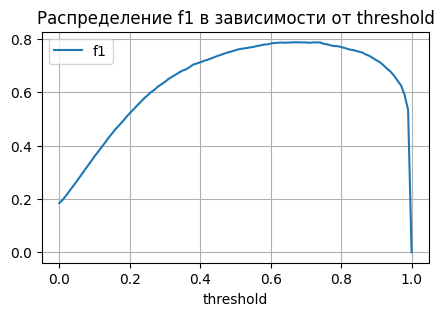

f1_max = 0.7879 при threshold = 0.67


In [53]:
threshold(probability)

In [54]:
best_results = pd.DataFrame(columns=['model', 'coding', 'hyperparameters', 'f1'])

def best_results_collector(model=None, coding=None, hyperparameters=None, f1=None):
    '''собирает df из лучших результатов'''
    global best_results
    best_results = pd.concat([best_results, pd.DataFrame(data   =[[model, coding, hyperparameters, f1]],
                                                         columns=['model', 'coding', 'hyperparameters', 'f1'])])

In [55]:
best_results_collector(model           = 'LogisticRegression', 
                       coding          = 'TF-IDF', 
                       hyperparameters = 'threshold = 0.67, balanced, lbfgs', 
                       f1              = 0.7879)

#### Bert

In [56]:
%%time
# расчёт f1 при различных solver
for s in ('lbfgs', 'liblinear'):
    f1 = lr(X_train_bert, Y_train, X_valid_bert, Y_valid, solver=s)
    print(f'f1 = {f1} при solver = {s}')

f1 = 0.7316 при solver = lbfgs
f1 = 0.7329 при solver = liblinear
CPU times: total: 1min 8s
Wall time: 37.7 s


Алгоритм 'liblinear' даёт более высокую метрику, используем его.

**class_weight  'balanced'**

In [57]:
print(f"f1 = {lr(X_train_bert, Y_train, X_valid_bert, Y_valid, class_weight='balanced', solver='liblinear')}")

f1 = 0.6558


При балансировке метрика падает, не используем.

**threshold**

Пробуем варьировать порог.

In [58]:
%%time
model = LogisticRegression(random_state = constant, max_iter=1000, solver='liblinear')
model.fit(X_train_bert, Y_train)
probability = model.predict_proba(X_valid_bert)[:,1]

CPU times: total: 29.8 s
Wall time: 29.8 s


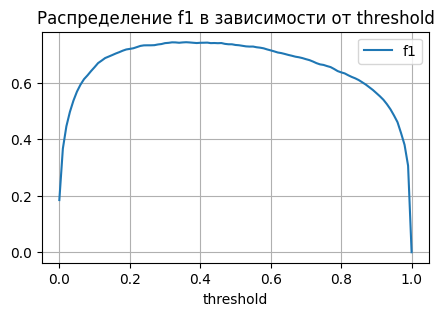

f1_max = 0.7426 при threshold = 0.36


In [59]:
threshold(probability)

In [60]:
best_results_collector(model           = 'LogisticRegression', 
                       coding          = 'Bert', 
                       hyperparameters = 'threshold = 0.36, liblinear', 
                       f1              = 0.7426)

#### Bert (toxic)

In [61]:
%%time
# расчёт f1 при различных solver
for s in ('lbfgs', 'liblinear'):
    f1 = lr(X_train_bert_toxic, Y_train, X_valid_bert_toxic, Y_valid, solver=s)
    print(f'f1 = {f1} при solver = {s}')

f1 = 0.949 при solver = lbfgs
f1 = 0.9486 при solver = liblinear
CPU times: total: 55.2 s
Wall time: 36.5 s


Алгоритм 'lbfgs' даёт более высокую метрику, используем его.

**class_weight  'balanced'**

In [62]:
print(f"f1 = {lr(X_train_bert_toxic, Y_train, X_valid_bert_toxic, Y_valid, class_weight='balanced')}")

f1 = 0.9256


При балансировке метрика падает, не используем.

**threshold**

Пробуем варьировать порог.

In [63]:
%%time
model = LogisticRegression(random_state = constant, max_iter=1000)
model.fit(X_train_bert_toxic, Y_train)
probability = model.predict_proba(X_valid_bert_toxic)[:,1]

CPU times: total: 23.5 s
Wall time: 4.79 s


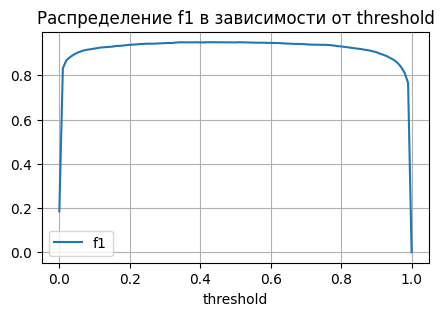

f1_max = 0.9498 при threshold = 0.42


In [64]:
threshold(probability)

In [65]:
best_results_collector(model           = 'LogisticRegression', 
                       coding          = 'Bert_toxic', 
                       hyperparameters = 'lbfgs, threshold = 0.42', 
                       f1              = 0.9498)

### DecisionTreeClassifier

#### TF-IDF

In [66]:
def dtc(X_train, Y_train, X_valid, Y_valid, depth = None, class_weight=None):
    '''расчёт f1 с помощью DecisionTreeClassifier'''
    model = DecisionTreeClassifier(random_state=constant, max_depth=depth, class_weight=class_weight)
    model.fit(X_train, Y_train)
    return f1_score(Y_valid, model.predict(X_valid)).round(4)

In [67]:
%%time
# расчёт f1 на несбалансированной и сбалансированной выборке
for cw in notebook.tqdm((None, 'balanced')):
    f1 = dtc(X_train_tfidf, Y_train, X_valid_tfidf, Y_valid, class_weight=cw)
    print(f'f1 = {f1} при class_weight = {cw}')

  0%|          | 0/2 [00:00<?, ?it/s]

f1 = 0.7127 при class_weight = None
f1 = 0.6632 при class_weight = balanced
CPU times: total: 4min 3s
Wall time: 4min 4s


Лучший результат с несбалансированной выборкой. Далее работаем с ней.

In [68]:
%%time
# расчёт f1 на различных глубинах дерева
for d in notebook.tqdm(range(4,37,2)):
    f1 = dtc(X_train_tfidf, Y_train, X_valid_tfidf, Y_valid, depth=d)
    print(f'f1 = {f1} при depth = {d}')

  0%|          | 0/17 [00:00<?, ?it/s]

f1 = 0.4812 при depth = 4
f1 = 0.5425 при depth = 6
f1 = 0.5787 при depth = 8
f1 = 0.6026 при depth = 10
f1 = 0.6214 при depth = 12
f1 = 0.6343 при depth = 14
f1 = 0.6463 при depth = 16
f1 = 0.6522 при depth = 18
f1 = 0.6612 при depth = 20
f1 = 0.6644 при depth = 22
f1 = 0.6738 при depth = 24
f1 = 0.6783 при depth = 26
f1 = 0.6852 при depth = 28
f1 = 0.6815 при depth = 30
f1 = 0.6909 при depth = 32
f1 = 0.695 при depth = 34
f1 = 0.6917 при depth = 36
CPU times: total: 2min 10s
Wall time: 2min 10s


In [69]:
%%time
dtc(X_train_tfidf, Y_train, X_valid_tfidf, Y_valid, depth=150)

CPU times: total: 50.9 s
Wall time: 51 s


0.7374

Заметно улучшение метрики с ростом глубины дерева, но и значительно возрастает время обработки.<br>
Логистическая регрессия и быстрее, и качественнее.

In [70]:
best_results_collector(model           = 'DecisionTreeClassifier', 
                       coding          = 'TF-IDF', 
                       hyperparameters = 'depth = 150', 
                       f1              = 0.7374)

#### Bert

In [71]:
%%time
# расчёт f1 на несбалансированной и сбалансированной выборке
for cw in notebook.tqdm((None, 'balanced')):
    f1 = dtc(X_train_bert, Y_train, X_valid_bert, Y_valid, class_weight=cw)
    print(f'f1 = {f1} при class_weight = {cw}')

  0%|          | 0/2 [00:00<?, ?it/s]

f1 = 0.4446 при class_weight = None
f1 = 0.4683 при class_weight = balanced
CPU times: total: 9min 28s
Wall time: 9min 28s


Лучший результат с балансированной выборкой. Далее работаем с ней.

In [72]:
%%time
# расчёт f1 на различных глубинах дерева
for d in notebook.tqdm(range(6,21,2)):
    f1 = dtc(X_train_bert, Y_train, X_valid_bert, Y_valid, depth=d, class_weight='balanced')
    print(f'f1 = {f1} при depth = {d}')

  0%|          | 0/8 [00:00<?, ?it/s]

f1 = 0.4316 при depth = 6
f1 = 0.4438 при depth = 8
f1 = 0.4633 при depth = 10
f1 = 0.495 при depth = 12
f1 = 0.5098 при depth = 14
f1 = 0.5178 при depth = 16
f1 = 0.514 при depth = 18
f1 = 0.5164 при depth = 20
CPU times: total: 14min 52s
Wall time: 14min 52s


Заметно улучшение метрики с ростом глубины дерева, но и значительно возрастает время обработки.<br>
Логистическая регрессия и быстрее, и качественнее.

In [73]:
best_results_collector(model           = 'DecisionTreeClassifier', 
                       coding          = 'Bert', 
                       hyperparameters = 'depth = 20, balanced', 
                       f1              = 0.5164)

#### Bert (toxic)

In [74]:
%%time
# расчёт f1 на несбалансированной и сбалансированной выборке
for cw in notebook.tqdm((None, 'balanced')):
    f1 = dtc(X_train_bert_toxic, Y_train, X_valid_bert_toxic, Y_valid, class_weight=cw)
    print(f'f1 = {f1} при class_weight = {cw}')

  0%|          | 0/2 [00:00<?, ?it/s]

f1 = 0.9173 при class_weight = None
f1 = 0.9089 при class_weight = balanced
CPU times: total: 10min 7s
Wall time: 10min 7s


Лучший результат с несбалансированной выборкой. Далее работаем с ней.

In [75]:
%%time
# расчёт f1 на различных глубинах дерева
for d in notebook.tqdm(range(1,10,2)):
    f1 = dtc(X_train_bert_toxic, Y_train, X_valid_bert_toxic, Y_valid, depth=d)
    print(f'f1 = {f1} при depth = {d}')

  0%|          | 0/5 [00:00<?, ?it/s]

f1 = 0.9254 при depth = 1
f1 = 0.9367 при depth = 3
f1 = 0.9383 при depth = 5
f1 = 0.9348 при depth = 7
f1 = 0.9312 при depth = 9
CPU times: total: 4min 1s
Wall time: 4min 1s


Расчёт несоизмеримо дольше логистической регрессии.

In [76]:
best_results_collector(model           = 'DecisionTreeClassifier', 
                       coding          = 'Bert_toxic', 
                       hyperparameters = 'depth = 5', 
                       f1              = 0.9383)

### RandomForestClassifier

#### TF-IDF

In [77]:
def rfc(X_train, Y_train, X_valid, Y_valid, depth = None, n_estimators=100, class_weight=None):
    '''расчёт f1 с помощью RandomForestClassifier'''
    model = RandomForestClassifier(random_state=constant, max_depth=depth, n_estimators=n_estimators, class_weight=class_weight)
    model.fit(X_train, Y_train)
    return f1_score(Y_valid, model.predict(X_valid)).round(4)

In [78]:
%%time
# расчёт f1 на несбалансированной и сбалансированной выборке
for cw in notebook.tqdm((None, 'balanced')):
    f1 = rfc(X_train_tfidf, Y_train, X_valid_tfidf, Y_valid, class_weight=cw)
    print(f'f1 = {f1} при class_weight = {cw}')

  0%|          | 0/2 [00:00<?, ?it/s]

f1 = 0.7174 при class_weight = None
f1 = 0.6504 при class_weight = balanced
CPU times: total: 13min 32s
Wall time: 13min 32s


Лучший результат с несбалансированной выборкой. Далее работаем с ней.

In [79]:
%%time
# расчёт f1 на различных глубинах дерева при постоянном числе деревьев (несбалансированная выборка)
for d in notebook.tqdm(range(5,51,5)):
    f1 = rfc(X_train_tfidf, Y_train, X_valid_tfidf, Y_valid, depth=d)
    print(f'f1 = {f1} при depth = {d}')

  0%|          | 0/10 [00:00<?, ?it/s]

f1 = 0.0 при depth = 5
f1 = 0.0 при depth = 10
f1 = 0.0 при depth = 15
f1 = 0.0025 при depth = 20
f1 = 0.0055 при depth = 25
f1 = 0.0141 при depth = 30
f1 = 0.0178 при depth = 35
f1 = 0.0352 при depth = 40
f1 = 0.0423 при depth = 45
f1 = 0.0547 при depth = 50
CPU times: total: 2min 14s
Wall time: 2min 14s


In [80]:
%%time
# расчёт f1 на различных глубинах дерева при постоянном числе деревьев (сбалансированная выборка)
for d in notebook.tqdm(range(5,51,5)):
    f1 = rfc(X_train_tfidf, Y_train, X_valid_tfidf, Y_valid, depth=d, class_weight = 'balanced')
    print(f'f1 = {f1} при depth = {d}')

  0%|          | 0/10 [00:00<?, ?it/s]

f1 = 0.3731 при depth = 5
f1 = 0.3765 при depth = 10
f1 = 0.3934 при depth = 15
f1 = 0.4117 при depth = 20
f1 = 0.4334 при depth = 25
f1 = 0.4456 при depth = 30
f1 = 0.4613 при depth = 35
f1 = 0.4702 при depth = 40
f1 = 0.4786 при depth = 45
f1 = 0.4895 при depth = 50
CPU times: total: 3min 2s
Wall time: 3min 2s


Заметно улучшение метрики с ростом глубины дерева, но и значительно возрастает время обработки.<br>

In [81]:
best_results_collector(model           = 'RandomForestClassifier', 
                       coding          = 'TF-IDF', 
                       hyperparameters = 'n_est=100, depth = max', 
                       f1              = 0.7174)

#### Bert

In [82]:
%%time
# расчёт f1 на несбалансированной и сбалансированной выборке
for cw in notebook.tqdm((None, 'balanced')):
    f1 = rfc(X_train_bert, Y_train, X_valid_bert, Y_valid, class_weight=cw)
    print(f'f1 = {f1} при class_weight = {cw}')

  0%|          | 0/2 [00:00<?, ?it/s]

f1 = 0.4898 при class_weight = None
f1 = 0.4763 при class_weight = balanced
CPU times: total: 13min 22s
Wall time: 13min 22s


Лучший результат с несбалансированной выборкой. Далее работаем с ней.

In [83]:
%%time
# расчёт f1 на различных глубинах дерева при постоянном числе деревьев
for d in notebook.tqdm(range(5,21,5)):
    f1 = rfc(X_train_bert, Y_train, X_valid_bert, Y_valid, depth=d)
    print(f'f1 = {f1} при depth = {d}')

  0%|          | 0/4 [00:00<?, ?it/s]

f1 = 0.1962 при depth = 5
f1 = 0.4425 при depth = 10
f1 = 0.4971 при depth = 15
f1 = 0.5017 при depth = 20
CPU times: total: 16min 42s
Wall time: 16min 42s


Можно было бы немного увеличить метрику за счёт большей глубины, но время выполнения неоправданно большое, а f1 значительно меньше быстрой логистической регрессии.

In [84]:
best_results_collector(model           = 'RandomForestClassifier', 
                       coding          = 'Bert', 
                       hyperparameters = 'depth = 20, n_esimators = 100', 
                       f1              = 0.5017)

#### Bert (toxic)

In [85]:
%%time
# расчёт f1 на несбалансированной и сбалансированной выборке
for cw in notebook.tqdm((None, 'balanced')):
    f1 = rfc(X_train_bert_toxic, Y_train, X_valid_bert_toxic, Y_valid, class_weight=cw)
    print(f'f1 = {f1} при class_weight = {cw}')

  0%|          | 0/2 [00:00<?, ?it/s]

f1 = 0.9472 при class_weight = None
f1 = 0.9429 при class_weight = balanced
CPU times: total: 13min 4s
Wall time: 13min 4s


Лучший результат с несбалансированной выборкой. Далее работаем с ней.

In [86]:
%%time
# расчёт f1 на различных глубинах дерева при постоянном числе деревьев
for d in notebook.tqdm(range(5,21,5)):
    f1 = rfc(X_train_bert_toxic, Y_train, X_valid_bert_toxic, Y_valid, depth=d)
    print(f'f1 = {f1} при depth = {d}')

  0%|          | 0/4 [00:00<?, ?it/s]

f1 = 0.9441 при depth = 5
f1 = 0.9461 при depth = 10
f1 = 0.9462 при depth = 15
f1 = 0.9449 при depth = 20
CPU times: total: 17min 55s
Wall time: 17min 55s


In [87]:
best_results_collector(model           = 'RandomForestClassifier', 
                       coding          = 'Bert_toxic', 
                       hyperparameters = 'n_esimators = 100, depth = max', 
                       f1              = 0.9472)

### LightGBM

#### TF-IDF

In [88]:
def lgb_func(X_train, Y_train, X_valid, Y_valid, learning_rate=0.1, max_depth=None, num_leaves = 1000, class_weight=None):
    train_data = lgb.Dataset(X_train, label=Y_train)
    valid_data = lgb.Dataset(X_valid, label=Y_valid)

    param = {'objective':     'binary',
             'learning_rate':  learning_rate,
             'max_depth':      max_depth,
             'num_leaves':     num_leaves,
             'early_stopping': 10,
             'class_weight':   class_weight,
             'verbose':        -1}

    model = lgb.train(param, train_data, num_boost_round=5000, valid_sets = valid_data)

    return f1_score(Y_valid, model.predict(X_valid).round())

In [89]:
%%time
# расчёт f1 на несбалансированной и сбалансированной выборке
for cw in notebook.tqdm((None, 'balanced')):
    f1 = lgb_func(X_train_tfidf, Y_train, X_valid_tfidf, Y_valid, class_weight=cw, learning_rate=0.5)

    print(colored(f'f1 = {f1:.4} при class_weight = {cw}\n', 'red', attrs=["bold"]))

  0%|          | 0/2 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.174573
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.155431
[3]	valid_0's binary_logloss: 0.146027
[4]	valid_0's binary_logloss: 0.140461
[5]	valid_0's binary_logloss: 0.136979
[6]	valid_0's binary_logloss: 0.135628
[7]	valid_0's binary_logloss: 0.134969
[8]	valid_0's binary_logloss: 0.136731
[9]	valid_0's binary_logloss: 0.139199
[10]	valid_0's binary_logloss: 0.141864
[11]	valid_0's binary_logloss: 0.144442
[12]	valid_0's binary_logloss: 0.147305
[13]	valid_0's binary_logloss: 0.149583
[14]	valid_0's binary_logloss: 0.153287
[15]	valid_0's binary_logloss: 0.156191
[16]	valid_0's binary_logloss: 0.159823
[17]	valid_0's binary_logloss: 0.163676
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.134969
f1 = 0.7515 при class_weight = None

[LightGBM] [Warning] Unknown parameter: class_weight
[1]	valid_0's binary_logloss: 0.174573
Training until validation scores don't improve for 10 rounds
[2]	

Результат не зависит от балансировки. Используем далее выборки по умолчанию без балансировки.

In [90]:
%%time
# расчёт f1 в зависимости от глубины дерева
for d in notebook.tqdm(range(3,15)):
    f1 = lgb_func(X_train_tfidf, Y_train, X_valid_tfidf, Y_valid, max_depth=d, learning_rate=0.5)


    print(colored(f'f1 = {f1:.4} при depth = {d}\n', 'red', attrs=["bold"]))

  0%|          | 0/12 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.265508
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.243185
[3]	valid_0's binary_logloss: 0.228616
[4]	valid_0's binary_logloss: 0.219887
[5]	valid_0's binary_logloss: 0.210826
[6]	valid_0's binary_logloss: 0.204697
[7]	valid_0's binary_logloss: 0.200348
[8]	valid_0's binary_logloss: 0.195753
[9]	valid_0's binary_logloss: 0.191699
[10]	valid_0's binary_logloss: 0.188577
[11]	valid_0's binary_logloss: 0.186665
[12]	valid_0's binary_logloss: 0.184453
[13]	valid_0's binary_logloss: 0.182186
[14]	valid_0's binary_logloss: 0.179244
[15]	valid_0's binary_logloss: 0.177266
[16]	valid_0's binary_logloss: 0.175695
[17]	valid_0's binary_logloss: 0.174427
[18]	valid_0's binary_logloss: 0.173419
[19]	valid_0's binary_logloss: 0.171978
[20]	valid_0's binary_logloss: 0.170744
[21]	valid_0's binary_logloss: 0.169472
[22]	valid_0's binary_logloss: 0.16799
[23]	valid_0's binary_logloss: 0.167434
[24]	valid_0's binary_logloss

[206]	valid_0's binary_logloss: 0.131941
[207]	valid_0's binary_logloss: 0.131907
[208]	valid_0's binary_logloss: 0.131983
[209]	valid_0's binary_logloss: 0.131989
[210]	valid_0's binary_logloss: 0.131896
[211]	valid_0's binary_logloss: 0.131814
[212]	valid_0's binary_logloss: 0.131756
[213]	valid_0's binary_logloss: 0.131796
[214]	valid_0's binary_logloss: 0.131774
[215]	valid_0's binary_logloss: 0.131785
[216]	valid_0's binary_logloss: 0.131775
[217]	valid_0's binary_logloss: 0.131756
[218]	valid_0's binary_logloss: 0.131728
[219]	valid_0's binary_logloss: 0.131685
[220]	valid_0's binary_logloss: 0.131603
[221]	valid_0's binary_logloss: 0.131509
[222]	valid_0's binary_logloss: 0.131425
[223]	valid_0's binary_logloss: 0.13138
[224]	valid_0's binary_logloss: 0.131352
[225]	valid_0's binary_logloss: 0.131328
[226]	valid_0's binary_logloss: 0.131251
[227]	valid_0's binary_logloss: 0.131227
[228]	valid_0's binary_logloss: 0.131224
[229]	valid_0's binary_logloss: 0.131235
[230]	valid_0's b

[28]	valid_0's binary_logloss: 0.150512
[29]	valid_0's binary_logloss: 0.149967
[30]	valid_0's binary_logloss: 0.149451
[31]	valid_0's binary_logloss: 0.148995
[32]	valid_0's binary_logloss: 0.148478
[33]	valid_0's binary_logloss: 0.148211
[34]	valid_0's binary_logloss: 0.147536
[35]	valid_0's binary_logloss: 0.14778
[36]	valid_0's binary_logloss: 0.147101
[37]	valid_0's binary_logloss: 0.146697
[38]	valid_0's binary_logloss: 0.146168
[39]	valid_0's binary_logloss: 0.145977
[40]	valid_0's binary_logloss: 0.14563
[41]	valid_0's binary_logloss: 0.145424
[42]	valid_0's binary_logloss: 0.144962
[43]	valid_0's binary_logloss: 0.144516
[44]	valid_0's binary_logloss: 0.144524
[45]	valid_0's binary_logloss: 0.144251
[46]	valid_0's binary_logloss: 0.143737
[47]	valid_0's binary_logloss: 0.14318
[48]	valid_0's binary_logloss: 0.142761
[49]	valid_0's binary_logloss: 0.142358
[50]	valid_0's binary_logloss: 0.141937
[51]	valid_0's binary_logloss: 0.141585
[52]	valid_0's binary_logloss: 0.141465
[53

[33]	valid_0's binary_logloss: 0.147431
[34]	valid_0's binary_logloss: 0.14676
[35]	valid_0's binary_logloss: 0.146992
[36]	valid_0's binary_logloss: 0.146253
[37]	valid_0's binary_logloss: 0.145854
[38]	valid_0's binary_logloss: 0.145248
[39]	valid_0's binary_logloss: 0.144699
[40]	valid_0's binary_logloss: 0.144023
[41]	valid_0's binary_logloss: 0.14355
[42]	valid_0's binary_logloss: 0.143009
[43]	valid_0's binary_logloss: 0.142848
[44]	valid_0's binary_logloss: 0.142629
[45]	valid_0's binary_logloss: 0.142304
[46]	valid_0's binary_logloss: 0.141864
[47]	valid_0's binary_logloss: 0.141481
[48]	valid_0's binary_logloss: 0.141195
[49]	valid_0's binary_logloss: 0.140664
[50]	valid_0's binary_logloss: 0.140573
[51]	valid_0's binary_logloss: 0.140369
[52]	valid_0's binary_logloss: 0.140266
[53]	valid_0's binary_logloss: 0.14012
[54]	valid_0's binary_logloss: 0.140031
[55]	valid_0's binary_logloss: 0.14025
[56]	valid_0's binary_logloss: 0.139931
[57]	valid_0's binary_logloss: 0.139964
[58]

[55]	valid_0's binary_logloss: 0.137839
[56]	valid_0's binary_logloss: 0.137837
[57]	valid_0's binary_logloss: 0.137495
[58]	valid_0's binary_logloss: 0.13732
[59]	valid_0's binary_logloss: 0.137102
[60]	valid_0's binary_logloss: 0.137076
[61]	valid_0's binary_logloss: 0.136905
[62]	valid_0's binary_logloss: 0.136548
[63]	valid_0's binary_logloss: 0.136476
[64]	valid_0's binary_logloss: 0.136149
[65]	valid_0's binary_logloss: 0.136069
[66]	valid_0's binary_logloss: 0.135865
[67]	valid_0's binary_logloss: 0.13559
[68]	valid_0's binary_logloss: 0.135379
[69]	valid_0's binary_logloss: 0.135407
[70]	valid_0's binary_logloss: 0.135399
[71]	valid_0's binary_logloss: 0.135262
[72]	valid_0's binary_logloss: 0.135079
[73]	valid_0's binary_logloss: 0.135058
[74]	valid_0's binary_logloss: 0.134565
[75]	valid_0's binary_logloss: 0.134662
[76]	valid_0's binary_logloss: 0.134653
[77]	valid_0's binary_logloss: 0.13462
[78]	valid_0's binary_logloss: 0.134562
[79]	valid_0's binary_logloss: 0.134522
[80

[31]	valid_0's binary_logloss: 0.1414
[32]	valid_0's binary_logloss: 0.141248
[33]	valid_0's binary_logloss: 0.140944
[34]	valid_0's binary_logloss: 0.1403
[35]	valid_0's binary_logloss: 0.140094
[36]	valid_0's binary_logloss: 0.139467
[37]	valid_0's binary_logloss: 0.139034
[38]	valid_0's binary_logloss: 0.138924
[39]	valid_0's binary_logloss: 0.138346
[40]	valid_0's binary_logloss: 0.138172
[41]	valid_0's binary_logloss: 0.138537
[42]	valid_0's binary_logloss: 0.138271
[43]	valid_0's binary_logloss: 0.137981
[44]	valid_0's binary_logloss: 0.137618
[45]	valid_0's binary_logloss: 0.137399
[46]	valid_0's binary_logloss: 0.136972
[47]	valid_0's binary_logloss: 0.136913
[48]	valid_0's binary_logloss: 0.136992
[49]	valid_0's binary_logloss: 0.136997
[50]	valid_0's binary_logloss: 0.137087
[51]	valid_0's binary_logloss: 0.136578
[52]	valid_0's binary_logloss: 0.13657
[53]	valid_0's binary_logloss: 0.136537
[54]	valid_0's binary_logloss: 0.136082
[55]	valid_0's binary_logloss: 0.135989
[56]	

[18]	valid_0's binary_logloss: 0.147658
[19]	valid_0's binary_logloss: 0.146643
[20]	valid_0's binary_logloss: 0.145893
[21]	valid_0's binary_logloss: 0.14434
[22]	valid_0's binary_logloss: 0.143758
[23]	valid_0's binary_logloss: 0.143318
[24]	valid_0's binary_logloss: 0.14292
[25]	valid_0's binary_logloss: 0.14218
[26]	valid_0's binary_logloss: 0.141444
[27]	valid_0's binary_logloss: 0.141413
[28]	valid_0's binary_logloss: 0.141217
[29]	valid_0's binary_logloss: 0.140854
[30]	valid_0's binary_logloss: 0.140311
[31]	valid_0's binary_logloss: 0.140014
[32]	valid_0's binary_logloss: 0.139673
[33]	valid_0's binary_logloss: 0.139173
[34]	valid_0's binary_logloss: 0.139168
[35]	valid_0's binary_logloss: 0.139016
[36]	valid_0's binary_logloss: 0.138848
[37]	valid_0's binary_logloss: 0.13867
[38]	valid_0's binary_logloss: 0.138754
[39]	valid_0's binary_logloss: 0.138636
[40]	valid_0's binary_logloss: 0.138569
[41]	valid_0's binary_logloss: 0.138355
[42]	valid_0's binary_logloss: 0.138279
[43]

[70]	valid_0's binary_logloss: 0.135326
[71]	valid_0's binary_logloss: 0.135299
[72]	valid_0's binary_logloss: 0.135082
[73]	valid_0's binary_logloss: 0.135162
[74]	valid_0's binary_logloss: 0.135299
[75]	valid_0's binary_logloss: 0.135436
[76]	valid_0's binary_logloss: 0.135303
[77]	valid_0's binary_logloss: 0.135322
[78]	valid_0's binary_logloss: 0.135293
[79]	valid_0's binary_logloss: 0.135434
[80]	valid_0's binary_logloss: 0.135545
[81]	valid_0's binary_logloss: 0.13566
[82]	valid_0's binary_logloss: 0.13567
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.135082
f1 = 0.7601 при depth = 13

[1]	valid_0's binary_logloss: 0.217193
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.193581
[3]	valid_0's binary_logloss: 0.181207
[4]	valid_0's binary_logloss: 0.174134
[5]	valid_0's binary_logloss: 0.167579
[6]	valid_0's binary_logloss: 0.163565
[7]	valid_0's binary_logloss: 0.158938
[8]	valid_0's binary_logloss: 0.156453
[9]	va

Лучший результат f1 = 0.7671 при depth = 5, learning_rate=0.5.

In [92]:
%%time
# расчёт f1 в зависимости от learning_rate
for lr_ in notebook.tqdm((0.1, 0.01)):
    f1 = lgb_func(X_train_tfidf, Y_train, X_valid_tfidf, Y_valid, max_depth=5, learning_rate=lr_)

    print(colored(f'f1 = {f1:.4} при learning_rate = {lr_}\n', 'red', attrs=["bold"]))

  0%|          | 0/2 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.299689
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.28491
[3]	valid_0's binary_logloss: 0.275609
[4]	valid_0's binary_logloss: 0.267944
[5]	valid_0's binary_logloss: 0.26185
[6]	valid_0's binary_logloss: 0.256701
[7]	valid_0's binary_logloss: 0.252115
[8]	valid_0's binary_logloss: 0.248409
[9]	valid_0's binary_logloss: 0.244474
[10]	valid_0's binary_logloss: 0.241144
[11]	valid_0's binary_logloss: 0.238147
[12]	valid_0's binary_logloss: 0.235504
[13]	valid_0's binary_logloss: 0.233035
[14]	valid_0's binary_logloss: 0.230614
[15]	valid_0's binary_logloss: 0.228332
[16]	valid_0's binary_logloss: 0.226492
[17]	valid_0's binary_logloss: 0.224479
[18]	valid_0's binary_logloss: 0.2226
[19]	valid_0's binary_logloss: 0.220676
[20]	valid_0's binary_logloss: 0.21879
[21]	valid_0's binary_logloss: 0.217265
[22]	valid_0's binary_logloss: 0.215739
[23]	valid_0's binary_logloss: 0.214555
[24]	valid_0's binary_logloss: 0.

[203]	valid_0's binary_logloss: 0.147801
[204]	valid_0's binary_logloss: 0.147658
[205]	valid_0's binary_logloss: 0.147497
[206]	valid_0's binary_logloss: 0.147385
[207]	valid_0's binary_logloss: 0.147245
[208]	valid_0's binary_logloss: 0.147145
[209]	valid_0's binary_logloss: 0.147007
[210]	valid_0's binary_logloss: 0.146906
[211]	valid_0's binary_logloss: 0.146792
[212]	valid_0's binary_logloss: 0.146669
[213]	valid_0's binary_logloss: 0.146529
[214]	valid_0's binary_logloss: 0.146369
[215]	valid_0's binary_logloss: 0.146246
[216]	valid_0's binary_logloss: 0.146087
[217]	valid_0's binary_logloss: 0.145993
[218]	valid_0's binary_logloss: 0.145901
[219]	valid_0's binary_logloss: 0.145788
[220]	valid_0's binary_logloss: 0.145701
[221]	valid_0's binary_logloss: 0.145602
[222]	valid_0's binary_logloss: 0.145494
[223]	valid_0's binary_logloss: 0.145394
[224]	valid_0's binary_logloss: 0.145257
[225]	valid_0's binary_logloss: 0.145127
[226]	valid_0's binary_logloss: 0.145044
[227]	valid_0's 

[411]	valid_0's binary_logloss: 0.132189
[412]	valid_0's binary_logloss: 0.13213
[413]	valid_0's binary_logloss: 0.132106
[414]	valid_0's binary_logloss: 0.132072
[415]	valid_0's binary_logloss: 0.132046
[416]	valid_0's binary_logloss: 0.131981
[417]	valid_0's binary_logloss: 0.131934
[418]	valid_0's binary_logloss: 0.131931
[419]	valid_0's binary_logloss: 0.131897
[420]	valid_0's binary_logloss: 0.131857
[421]	valid_0's binary_logloss: 0.131812
[422]	valid_0's binary_logloss: 0.131768
[423]	valid_0's binary_logloss: 0.131717
[424]	valid_0's binary_logloss: 0.131692
[425]	valid_0's binary_logloss: 0.131602
[426]	valid_0's binary_logloss: 0.131567
[427]	valid_0's binary_logloss: 0.131489
[428]	valid_0's binary_logloss: 0.131442
[429]	valid_0's binary_logloss: 0.131426
[430]	valid_0's binary_logloss: 0.131368
[431]	valid_0's binary_logloss: 0.131336
[432]	valid_0's binary_logloss: 0.131302
[433]	valid_0's binary_logloss: 0.131256
[434]	valid_0's binary_logloss: 0.131206
[435]	valid_0's b

[612]	valid_0's binary_logloss: 0.126087
[613]	valid_0's binary_logloss: 0.126035
[614]	valid_0's binary_logloss: 0.126017
[615]	valid_0's binary_logloss: 0.125986
[616]	valid_0's binary_logloss: 0.125957
[617]	valid_0's binary_logloss: 0.125945
[618]	valid_0's binary_logloss: 0.125915
[619]	valid_0's binary_logloss: 0.125897
[620]	valid_0's binary_logloss: 0.125867
[621]	valid_0's binary_logloss: 0.125856
[622]	valid_0's binary_logloss: 0.125862
[623]	valid_0's binary_logloss: 0.125825
[624]	valid_0's binary_logloss: 0.125803
[625]	valid_0's binary_logloss: 0.125792
[626]	valid_0's binary_logloss: 0.12573
[627]	valid_0's binary_logloss: 0.125715
[628]	valid_0's binary_logloss: 0.125683
[629]	valid_0's binary_logloss: 0.125666
[630]	valid_0's binary_logloss: 0.125651
[631]	valid_0's binary_logloss: 0.125626
[632]	valid_0's binary_logloss: 0.125623
[633]	valid_0's binary_logloss: 0.1256
[634]	valid_0's binary_logloss: 0.125595
[635]	valid_0's binary_logloss: 0.125596
[636]	valid_0's bin

[814]	valid_0's binary_logloss: 0.122616
[815]	valid_0's binary_logloss: 0.122638
[816]	valid_0's binary_logloss: 0.122613
[817]	valid_0's binary_logloss: 0.122593
[818]	valid_0's binary_logloss: 0.12259
[819]	valid_0's binary_logloss: 0.122562
[820]	valid_0's binary_logloss: 0.122576
[821]	valid_0's binary_logloss: 0.12255
[822]	valid_0's binary_logloss: 0.122515
[823]	valid_0's binary_logloss: 0.122519
[824]	valid_0's binary_logloss: 0.122514
[825]	valid_0's binary_logloss: 0.122497
[826]	valid_0's binary_logloss: 0.122487
[827]	valid_0's binary_logloss: 0.122445
[828]	valid_0's binary_logloss: 0.122425
[829]	valid_0's binary_logloss: 0.122407
[830]	valid_0's binary_logloss: 0.122402
[831]	valid_0's binary_logloss: 0.12239
[832]	valid_0's binary_logloss: 0.122342
[833]	valid_0's binary_logloss: 0.122332
[834]	valid_0's binary_logloss: 0.122325
[835]	valid_0's binary_logloss: 0.1223
[836]	valid_0's binary_logloss: 0.122285
[837]	valid_0's binary_logloss: 0.122261
[838]	valid_0's binar

[1018]	valid_0's binary_logloss: 0.120545
[1019]	valid_0's binary_logloss: 0.120552
[1020]	valid_0's binary_logloss: 0.120533
[1021]	valid_0's binary_logloss: 0.120539
[1022]	valid_0's binary_logloss: 0.12051
[1023]	valid_0's binary_logloss: 0.120514
[1024]	valid_0's binary_logloss: 0.1205
[1025]	valid_0's binary_logloss: 0.120488
[1026]	valid_0's binary_logloss: 0.120473
[1027]	valid_0's binary_logloss: 0.12046
[1028]	valid_0's binary_logloss: 0.120458
[1029]	valid_0's binary_logloss: 0.120464
[1030]	valid_0's binary_logloss: 0.120472
[1031]	valid_0's binary_logloss: 0.120472
[1032]	valid_0's binary_logloss: 0.120465
[1033]	valid_0's binary_logloss: 0.12046
[1034]	valid_0's binary_logloss: 0.120433
[1035]	valid_0's binary_logloss: 0.120428
[1036]	valid_0's binary_logloss: 0.120426
[1037]	valid_0's binary_logloss: 0.12041
[1038]	valid_0's binary_logloss: 0.120397
[1039]	valid_0's binary_logloss: 0.120398
[1040]	valid_0's binary_logloss: 0.120381
[1041]	valid_0's binary_logloss: 0.12036

[58]	valid_0's binary_logloss: 0.262722
[59]	valid_0's binary_logloss: 0.26218
[60]	valid_0's binary_logloss: 0.261651
[61]	valid_0's binary_logloss: 0.261146
[62]	valid_0's binary_logloss: 0.260633
[63]	valid_0's binary_logloss: 0.260155
[64]	valid_0's binary_logloss: 0.25968
[65]	valid_0's binary_logloss: 0.259208
[66]	valid_0's binary_logloss: 0.25873
[67]	valid_0's binary_logloss: 0.25828
[68]	valid_0's binary_logloss: 0.257806
[69]	valid_0's binary_logloss: 0.257351
[70]	valid_0's binary_logloss: 0.256886
[71]	valid_0's binary_logloss: 0.256453
[72]	valid_0's binary_logloss: 0.256006
[73]	valid_0's binary_logloss: 0.255573
[74]	valid_0's binary_logloss: 0.255135
[75]	valid_0's binary_logloss: 0.254717
[76]	valid_0's binary_logloss: 0.254294
[77]	valid_0's binary_logloss: 0.253902
[78]	valid_0's binary_logloss: 0.253466
[79]	valid_0's binary_logloss: 0.253086
[80]	valid_0's binary_logloss: 0.252689
[81]	valid_0's binary_logloss: 0.252296
[82]	valid_0's binary_logloss: 0.251899
[83]

[261]	valid_0's binary_logloss: 0.213435
[262]	valid_0's binary_logloss: 0.213304
[263]	valid_0's binary_logloss: 0.213148
[264]	valid_0's binary_logloss: 0.213022
[265]	valid_0's binary_logloss: 0.212895
[266]	valid_0's binary_logloss: 0.212754
[267]	valid_0's binary_logloss: 0.212644
[268]	valid_0's binary_logloss: 0.212505
[269]	valid_0's binary_logloss: 0.212398
[270]	valid_0's binary_logloss: 0.212274
[271]	valid_0's binary_logloss: 0.212159
[272]	valid_0's binary_logloss: 0.212021
[273]	valid_0's binary_logloss: 0.211903
[274]	valid_0's binary_logloss: 0.21177
[275]	valid_0's binary_logloss: 0.211656
[276]	valid_0's binary_logloss: 0.211533
[277]	valid_0's binary_logloss: 0.211416
[278]	valid_0's binary_logloss: 0.211285
[279]	valid_0's binary_logloss: 0.211154
[280]	valid_0's binary_logloss: 0.211043
[281]	valid_0's binary_logloss: 0.210937
[282]	valid_0's binary_logloss: 0.210819
[283]	valid_0's binary_logloss: 0.210683
[284]	valid_0's binary_logloss: 0.210563
[285]	valid_0's b

[465]	valid_0's binary_logloss: 0.193789
[466]	valid_0's binary_logloss: 0.193727
[467]	valid_0's binary_logloss: 0.19366
[468]	valid_0's binary_logloss: 0.193578
[469]	valid_0's binary_logloss: 0.193521
[470]	valid_0's binary_logloss: 0.193437
[471]	valid_0's binary_logloss: 0.193362
[472]	valid_0's binary_logloss: 0.193292
[473]	valid_0's binary_logloss: 0.193225
[474]	valid_0's binary_logloss: 0.193151
[475]	valid_0's binary_logloss: 0.193086
[476]	valid_0's binary_logloss: 0.193003
[477]	valid_0's binary_logloss: 0.192937
[478]	valid_0's binary_logloss: 0.19287
[479]	valid_0's binary_logloss: 0.192807
[480]	valid_0's binary_logloss: 0.19274
[481]	valid_0's binary_logloss: 0.192672
[482]	valid_0's binary_logloss: 0.192597
[483]	valid_0's binary_logloss: 0.192527
[484]	valid_0's binary_logloss: 0.192463
[485]	valid_0's binary_logloss: 0.192389
[486]	valid_0's binary_logloss: 0.192326
[487]	valid_0's binary_logloss: 0.192251
[488]	valid_0's binary_logloss: 0.192188
[489]	valid_0's bin

[672]	valid_0's binary_logloss: 0.181697
[673]	valid_0's binary_logloss: 0.181641
[674]	valid_0's binary_logloss: 0.181598
[675]	valid_0's binary_logloss: 0.181551
[676]	valid_0's binary_logloss: 0.181508
[677]	valid_0's binary_logloss: 0.181469
[678]	valid_0's binary_logloss: 0.181423
[679]	valid_0's binary_logloss: 0.181371
[680]	valid_0's binary_logloss: 0.181315
[681]	valid_0's binary_logloss: 0.181275
[682]	valid_0's binary_logloss: 0.181236
[683]	valid_0's binary_logloss: 0.181188
[684]	valid_0's binary_logloss: 0.181134
[685]	valid_0's binary_logloss: 0.181092
[686]	valid_0's binary_logloss: 0.181045
[687]	valid_0's binary_logloss: 0.180986
[688]	valid_0's binary_logloss: 0.180941
[689]	valid_0's binary_logloss: 0.180888
[690]	valid_0's binary_logloss: 0.180842
[691]	valid_0's binary_logloss: 0.180796
[692]	valid_0's binary_logloss: 0.18075
[693]	valid_0's binary_logloss: 0.180696
[694]	valid_0's binary_logloss: 0.180648
[695]	valid_0's binary_logloss: 0.180609
[696]	valid_0's b

[879]	valid_0's binary_logloss: 0.173028
[880]	valid_0's binary_logloss: 0.172984
[881]	valid_0's binary_logloss: 0.17294
[882]	valid_0's binary_logloss: 0.1729
[883]	valid_0's binary_logloss: 0.172864
[884]	valid_0's binary_logloss: 0.172828
[885]	valid_0's binary_logloss: 0.172793
[886]	valid_0's binary_logloss: 0.172764
[887]	valid_0's binary_logloss: 0.172733
[888]	valid_0's binary_logloss: 0.172696
[889]	valid_0's binary_logloss: 0.172663
[890]	valid_0's binary_logloss: 0.172637
[891]	valid_0's binary_logloss: 0.1726
[892]	valid_0's binary_logloss: 0.172567
[893]	valid_0's binary_logloss: 0.172531
[894]	valid_0's binary_logloss: 0.172494
[895]	valid_0's binary_logloss: 0.172462
[896]	valid_0's binary_logloss: 0.17242
[897]	valid_0's binary_logloss: 0.172387
[898]	valid_0's binary_logloss: 0.172352
[899]	valid_0's binary_logloss: 0.172309
[900]	valid_0's binary_logloss: 0.172273
[901]	valid_0's binary_logloss: 0.172238
[902]	valid_0's binary_logloss: 0.172193
[903]	valid_0's binary

[1079]	valid_0's binary_logloss: 0.166631
[1080]	valid_0's binary_logloss: 0.166601
[1081]	valid_0's binary_logloss: 0.166567
[1082]	valid_0's binary_logloss: 0.166545
[1083]	valid_0's binary_logloss: 0.166507
[1084]	valid_0's binary_logloss: 0.166485
[1085]	valid_0's binary_logloss: 0.166452
[1086]	valid_0's binary_logloss: 0.166423
[1087]	valid_0's binary_logloss: 0.166394
[1088]	valid_0's binary_logloss: 0.166371
[1089]	valid_0's binary_logloss: 0.166345
[1090]	valid_0's binary_logloss: 0.166318
[1091]	valid_0's binary_logloss: 0.166298
[1092]	valid_0's binary_logloss: 0.166265
[1093]	valid_0's binary_logloss: 0.166234
[1094]	valid_0's binary_logloss: 0.166196
[1095]	valid_0's binary_logloss: 0.166176
[1096]	valid_0's binary_logloss: 0.166156
[1097]	valid_0's binary_logloss: 0.166136
[1098]	valid_0's binary_logloss: 0.166107
[1099]	valid_0's binary_logloss: 0.166069
[1100]	valid_0's binary_logloss: 0.166038
[1101]	valid_0's binary_logloss: 0.166015
[1102]	valid_0's binary_logloss: 0

[1277]	valid_0's binary_logloss: 0.161683
[1278]	valid_0's binary_logloss: 0.161668
[1279]	valid_0's binary_logloss: 0.161645
[1280]	valid_0's binary_logloss: 0.161625
[1281]	valid_0's binary_logloss: 0.161601
[1282]	valid_0's binary_logloss: 0.161578
[1283]	valid_0's binary_logloss: 0.161561
[1284]	valid_0's binary_logloss: 0.161538
[1285]	valid_0's binary_logloss: 0.161518
[1286]	valid_0's binary_logloss: 0.161496
[1287]	valid_0's binary_logloss: 0.161471
[1288]	valid_0's binary_logloss: 0.161438
[1289]	valid_0's binary_logloss: 0.161416
[1290]	valid_0's binary_logloss: 0.161397
[1291]	valid_0's binary_logloss: 0.16138
[1292]	valid_0's binary_logloss: 0.161357
[1293]	valid_0's binary_logloss: 0.161341
[1294]	valid_0's binary_logloss: 0.161319
[1295]	valid_0's binary_logloss: 0.161298
[1296]	valid_0's binary_logloss: 0.161284
[1297]	valid_0's binary_logloss: 0.161268
[1298]	valid_0's binary_logloss: 0.161241
[1299]	valid_0's binary_logloss: 0.161215
[1300]	valid_0's binary_logloss: 0.

[1478]	valid_0's binary_logloss: 0.157483
[1479]	valid_0's binary_logloss: 0.15747
[1480]	valid_0's binary_logloss: 0.157449
[1481]	valid_0's binary_logloss: 0.157423
[1482]	valid_0's binary_logloss: 0.157409
[1483]	valid_0's binary_logloss: 0.157398
[1484]	valid_0's binary_logloss: 0.157382
[1485]	valid_0's binary_logloss: 0.157367
[1486]	valid_0's binary_logloss: 0.157349
[1487]	valid_0's binary_logloss: 0.157336
[1488]	valid_0's binary_logloss: 0.157316
[1489]	valid_0's binary_logloss: 0.157295
[1490]	valid_0's binary_logloss: 0.15728
[1491]	valid_0's binary_logloss: 0.157264
[1492]	valid_0's binary_logloss: 0.157241
[1493]	valid_0's binary_logloss: 0.157224
[1494]	valid_0's binary_logloss: 0.157212
[1495]	valid_0's binary_logloss: 0.157196
[1496]	valid_0's binary_logloss: 0.157181
[1497]	valid_0's binary_logloss: 0.157162
[1498]	valid_0's binary_logloss: 0.157141
[1499]	valid_0's binary_logloss: 0.157129
[1500]	valid_0's binary_logloss: 0.157107
[1501]	valid_0's binary_logloss: 0.1

[1675]	valid_0's binary_logloss: 0.154039
[1676]	valid_0's binary_logloss: 0.154023
[1677]	valid_0's binary_logloss: 0.154008
[1678]	valid_0's binary_logloss: 0.153995
[1679]	valid_0's binary_logloss: 0.15398
[1680]	valid_0's binary_logloss: 0.153965
[1681]	valid_0's binary_logloss: 0.153952
[1682]	valid_0's binary_logloss: 0.153932
[1683]	valid_0's binary_logloss: 0.15391
[1684]	valid_0's binary_logloss: 0.153893
[1685]	valid_0's binary_logloss: 0.153874
[1686]	valid_0's binary_logloss: 0.153859
[1687]	valid_0's binary_logloss: 0.153841
[1688]	valid_0's binary_logloss: 0.153829
[1689]	valid_0's binary_logloss: 0.153809
[1690]	valid_0's binary_logloss: 0.153794
[1691]	valid_0's binary_logloss: 0.153773
[1692]	valid_0's binary_logloss: 0.15375
[1693]	valid_0's binary_logloss: 0.153739
[1694]	valid_0's binary_logloss: 0.153719
[1695]	valid_0's binary_logloss: 0.1537
[1696]	valid_0's binary_logloss: 0.153687
[1697]	valid_0's binary_logloss: 0.153673
[1698]	valid_0's binary_logloss: 0.1536

[1878]	valid_0's binary_logloss: 0.150955
[1879]	valid_0's binary_logloss: 0.150941
[1880]	valid_0's binary_logloss: 0.15093
[1881]	valid_0's binary_logloss: 0.150918
[1882]	valid_0's binary_logloss: 0.1509
[1883]	valid_0's binary_logloss: 0.150885
[1884]	valid_0's binary_logloss: 0.150871
[1885]	valid_0's binary_logloss: 0.150859
[1886]	valid_0's binary_logloss: 0.150845
[1887]	valid_0's binary_logloss: 0.150826
[1888]	valid_0's binary_logloss: 0.150811
[1889]	valid_0's binary_logloss: 0.150802
[1890]	valid_0's binary_logloss: 0.150781
[1891]	valid_0's binary_logloss: 0.15076
[1892]	valid_0's binary_logloss: 0.150746
[1893]	valid_0's binary_logloss: 0.150727
[1894]	valid_0's binary_logloss: 0.15071
[1895]	valid_0's binary_logloss: 0.150698
[1896]	valid_0's binary_logloss: 0.150683
[1897]	valid_0's binary_logloss: 0.150668
[1898]	valid_0's binary_logloss: 0.150655
[1899]	valid_0's binary_logloss: 0.150639
[1900]	valid_0's binary_logloss: 0.150627
[1901]	valid_0's binary_logloss: 0.1506

[2078]	valid_0's binary_logloss: 0.148283
[2079]	valid_0's binary_logloss: 0.148273
[2080]	valid_0's binary_logloss: 0.148256
[2081]	valid_0's binary_logloss: 0.148243
[2082]	valid_0's binary_logloss: 0.148231
[2083]	valid_0's binary_logloss: 0.148219
[2084]	valid_0's binary_logloss: 0.148211
[2085]	valid_0's binary_logloss: 0.1482
[2086]	valid_0's binary_logloss: 0.148188
[2087]	valid_0's binary_logloss: 0.148175
[2088]	valid_0's binary_logloss: 0.148162
[2089]	valid_0's binary_logloss: 0.148147
[2090]	valid_0's binary_logloss: 0.148136
[2091]	valid_0's binary_logloss: 0.148119
[2092]	valid_0's binary_logloss: 0.148108
[2093]	valid_0's binary_logloss: 0.148096
[2094]	valid_0's binary_logloss: 0.148084
[2095]	valid_0's binary_logloss: 0.148075
[2096]	valid_0's binary_logloss: 0.148065
[2097]	valid_0's binary_logloss: 0.148057
[2098]	valid_0's binary_logloss: 0.148046
[2099]	valid_0's binary_logloss: 0.148034
[2100]	valid_0's binary_logloss: 0.14802
[2101]	valid_0's binary_logloss: 0.14

[2281]	valid_0's binary_logloss: 0.145963
[2282]	valid_0's binary_logloss: 0.145957
[2283]	valid_0's binary_logloss: 0.145951
[2284]	valid_0's binary_logloss: 0.145941
[2285]	valid_0's binary_logloss: 0.14593
[2286]	valid_0's binary_logloss: 0.145916
[2287]	valid_0's binary_logloss: 0.145903
[2288]	valid_0's binary_logloss: 0.145889
[2289]	valid_0's binary_logloss: 0.145881
[2290]	valid_0's binary_logloss: 0.145865
[2291]	valid_0's binary_logloss: 0.145854
[2292]	valid_0's binary_logloss: 0.145845
[2293]	valid_0's binary_logloss: 0.145836
[2294]	valid_0's binary_logloss: 0.14582
[2295]	valid_0's binary_logloss: 0.145809
[2296]	valid_0's binary_logloss: 0.145799
[2297]	valid_0's binary_logloss: 0.14579
[2298]	valid_0's binary_logloss: 0.145774
[2299]	valid_0's binary_logloss: 0.145762
[2300]	valid_0's binary_logloss: 0.145747
[2301]	valid_0's binary_logloss: 0.145735
[2302]	valid_0's binary_logloss: 0.145725
[2303]	valid_0's binary_logloss: 0.145717
[2304]	valid_0's binary_logloss: 0.14

[2480]	valid_0's binary_logloss: 0.143929
[2481]	valid_0's binary_logloss: 0.143919
[2482]	valid_0's binary_logloss: 0.14391
[2483]	valid_0's binary_logloss: 0.1439
[2484]	valid_0's binary_logloss: 0.143882
[2485]	valid_0's binary_logloss: 0.143874
[2486]	valid_0's binary_logloss: 0.143861
[2487]	valid_0's binary_logloss: 0.143854
[2488]	valid_0's binary_logloss: 0.14384
[2489]	valid_0's binary_logloss: 0.14383
[2490]	valid_0's binary_logloss: 0.143823
[2491]	valid_0's binary_logloss: 0.143813
[2492]	valid_0's binary_logloss: 0.143804
[2493]	valid_0's binary_logloss: 0.143797
[2494]	valid_0's binary_logloss: 0.14379
[2495]	valid_0's binary_logloss: 0.143779
[2496]	valid_0's binary_logloss: 0.143768
[2497]	valid_0's binary_logloss: 0.143758
[2498]	valid_0's binary_logloss: 0.143748
[2499]	valid_0's binary_logloss: 0.14374
[2500]	valid_0's binary_logloss: 0.143731
[2501]	valid_0's binary_logloss: 0.143721
[2502]	valid_0's binary_logloss: 0.143712
[2503]	valid_0's binary_logloss: 0.143704

[2678]	valid_0's binary_logloss: 0.142057
[2679]	valid_0's binary_logloss: 0.142049
[2680]	valid_0's binary_logloss: 0.142036
[2681]	valid_0's binary_logloss: 0.142032
[2682]	valid_0's binary_logloss: 0.142019
[2683]	valid_0's binary_logloss: 0.142013
[2684]	valid_0's binary_logloss: 0.141998
[2685]	valid_0's binary_logloss: 0.141994
[2686]	valid_0's binary_logloss: 0.141989
[2687]	valid_0's binary_logloss: 0.141982
[2688]	valid_0's binary_logloss: 0.141975
[2689]	valid_0's binary_logloss: 0.141963
[2690]	valid_0's binary_logloss: 0.141953
[2691]	valid_0's binary_logloss: 0.141946
[2692]	valid_0's binary_logloss: 0.141939
[2693]	valid_0's binary_logloss: 0.141933
[2694]	valid_0's binary_logloss: 0.141926
[2695]	valid_0's binary_logloss: 0.141916
[2696]	valid_0's binary_logloss: 0.141907
[2697]	valid_0's binary_logloss: 0.141903
[2698]	valid_0's binary_logloss: 0.141895
[2699]	valid_0's binary_logloss: 0.141887
[2700]	valid_0's binary_logloss: 0.14188
[2701]	valid_0's binary_logloss: 0.

[2876]	valid_0's binary_logloss: 0.140445
[2877]	valid_0's binary_logloss: 0.140438
[2878]	valid_0's binary_logloss: 0.140433
[2879]	valid_0's binary_logloss: 0.140424
[2880]	valid_0's binary_logloss: 0.140416
[2881]	valid_0's binary_logloss: 0.140411
[2882]	valid_0's binary_logloss: 0.140406
[2883]	valid_0's binary_logloss: 0.1404
[2884]	valid_0's binary_logloss: 0.140389
[2885]	valid_0's binary_logloss: 0.140381
[2886]	valid_0's binary_logloss: 0.140376
[2887]	valid_0's binary_logloss: 0.14037
[2888]	valid_0's binary_logloss: 0.140359
[2889]	valid_0's binary_logloss: 0.140352
[2890]	valid_0's binary_logloss: 0.14034
[2891]	valid_0's binary_logloss: 0.14033
[2892]	valid_0's binary_logloss: 0.140321
[2893]	valid_0's binary_logloss: 0.14031
[2894]	valid_0's binary_logloss: 0.140299
[2895]	valid_0's binary_logloss: 0.140287
[2896]	valid_0's binary_logloss: 0.14028
[2897]	valid_0's binary_logloss: 0.140276
[2898]	valid_0's binary_logloss: 0.140269
[2899]	valid_0's binary_logloss: 0.140261

[3078]	valid_0's binary_logloss: 0.138926
[3079]	valid_0's binary_logloss: 0.138919
[3080]	valid_0's binary_logloss: 0.138911
[3081]	valid_0's binary_logloss: 0.138905
[3082]	valid_0's binary_logloss: 0.138896
[3083]	valid_0's binary_logloss: 0.138891
[3084]	valid_0's binary_logloss: 0.138885
[3085]	valid_0's binary_logloss: 0.138876
[3086]	valid_0's binary_logloss: 0.138868
[3087]	valid_0's binary_logloss: 0.138859
[3088]	valid_0's binary_logloss: 0.138854
[3089]	valid_0's binary_logloss: 0.13885
[3090]	valid_0's binary_logloss: 0.138842
[3091]	valid_0's binary_logloss: 0.138837
[3092]	valid_0's binary_logloss: 0.138827
[3093]	valid_0's binary_logloss: 0.13882
[3094]	valid_0's binary_logloss: 0.138813
[3095]	valid_0's binary_logloss: 0.138803
[3096]	valid_0's binary_logloss: 0.138794
[3097]	valid_0's binary_logloss: 0.138783
[3098]	valid_0's binary_logloss: 0.138777
[3099]	valid_0's binary_logloss: 0.138773
[3100]	valid_0's binary_logloss: 0.138765
[3101]	valid_0's binary_logloss: 0.1

[3275]	valid_0's binary_logloss: 0.137571
[3276]	valid_0's binary_logloss: 0.137563
[3277]	valid_0's binary_logloss: 0.137555
[3278]	valid_0's binary_logloss: 0.137547
[3279]	valid_0's binary_logloss: 0.137541
[3280]	valid_0's binary_logloss: 0.137531
[3281]	valid_0's binary_logloss: 0.137526
[3282]	valid_0's binary_logloss: 0.137521
[3283]	valid_0's binary_logloss: 0.137513
[3284]	valid_0's binary_logloss: 0.13751
[3285]	valid_0's binary_logloss: 0.137497
[3286]	valid_0's binary_logloss: 0.137491
[3287]	valid_0's binary_logloss: 0.137485
[3288]	valid_0's binary_logloss: 0.137482
[3289]	valid_0's binary_logloss: 0.137475
[3290]	valid_0's binary_logloss: 0.137464
[3291]	valid_0's binary_logloss: 0.13746
[3292]	valid_0's binary_logloss: 0.137452
[3293]	valid_0's binary_logloss: 0.137448
[3294]	valid_0's binary_logloss: 0.137442
[3295]	valid_0's binary_logloss: 0.137434
[3296]	valid_0's binary_logloss: 0.137423
[3297]	valid_0's binary_logloss: 0.137415
[3298]	valid_0's binary_logloss: 0.1

[3475]	valid_0's binary_logloss: 0.136258
[3476]	valid_0's binary_logloss: 0.136253
[3477]	valid_0's binary_logloss: 0.136242
[3478]	valid_0's binary_logloss: 0.136237
[3479]	valid_0's binary_logloss: 0.136232
[3480]	valid_0's binary_logloss: 0.136227
[3481]	valid_0's binary_logloss: 0.136217
[3482]	valid_0's binary_logloss: 0.136212
[3483]	valid_0's binary_logloss: 0.136205
[3484]	valid_0's binary_logloss: 0.136198
[3485]	valid_0's binary_logloss: 0.136191
[3486]	valid_0's binary_logloss: 0.136186
[3487]	valid_0's binary_logloss: 0.136182
[3488]	valid_0's binary_logloss: 0.136177
[3489]	valid_0's binary_logloss: 0.136168
[3490]	valid_0's binary_logloss: 0.13616
[3491]	valid_0's binary_logloss: 0.136153
[3492]	valid_0's binary_logloss: 0.136148
[3493]	valid_0's binary_logloss: 0.136141
[3494]	valid_0's binary_logloss: 0.136133
[3495]	valid_0's binary_logloss: 0.136129
[3496]	valid_0's binary_logloss: 0.136126
[3497]	valid_0's binary_logloss: 0.136121
[3498]	valid_0's binary_logloss: 0.

[3675]	valid_0's binary_logloss: 0.135098
[3676]	valid_0's binary_logloss: 0.135094
[3677]	valid_0's binary_logloss: 0.135087
[3678]	valid_0's binary_logloss: 0.135082
[3679]	valid_0's binary_logloss: 0.13508
[3680]	valid_0's binary_logloss: 0.135076
[3681]	valid_0's binary_logloss: 0.135069
[3682]	valid_0's binary_logloss: 0.135062
[3683]	valid_0's binary_logloss: 0.135059
[3684]	valid_0's binary_logloss: 0.135053
[3685]	valid_0's binary_logloss: 0.135051
[3686]	valid_0's binary_logloss: 0.135048
[3687]	valid_0's binary_logloss: 0.13504
[3688]	valid_0's binary_logloss: 0.135037
[3689]	valid_0's binary_logloss: 0.135031
[3690]	valid_0's binary_logloss: 0.135025
[3691]	valid_0's binary_logloss: 0.135015
[3692]	valid_0's binary_logloss: 0.13501
[3693]	valid_0's binary_logloss: 0.135003
[3694]	valid_0's binary_logloss: 0.134997
[3695]	valid_0's binary_logloss: 0.134991
[3696]	valid_0's binary_logloss: 0.134986
[3697]	valid_0's binary_logloss: 0.134982
[3698]	valid_0's binary_logloss: 0.13

[3875]	valid_0's binary_logloss: 0.134033
[3876]	valid_0's binary_logloss: 0.13403
[3877]	valid_0's binary_logloss: 0.134022
[3878]	valid_0's binary_logloss: 0.134019
[3879]	valid_0's binary_logloss: 0.134013
[3880]	valid_0's binary_logloss: 0.134007
[3881]	valid_0's binary_logloss: 0.134002
[3882]	valid_0's binary_logloss: 0.133999
[3883]	valid_0's binary_logloss: 0.133994
[3884]	valid_0's binary_logloss: 0.133988
[3885]	valid_0's binary_logloss: 0.133984
[3886]	valid_0's binary_logloss: 0.133977
[3887]	valid_0's binary_logloss: 0.13397
[3888]	valid_0's binary_logloss: 0.133963
[3889]	valid_0's binary_logloss: 0.133961
[3890]	valid_0's binary_logloss: 0.133958
[3891]	valid_0's binary_logloss: 0.133954
[3892]	valid_0's binary_logloss: 0.133947
[3893]	valid_0's binary_logloss: 0.133944
[3894]	valid_0's binary_logloss: 0.133939
[3895]	valid_0's binary_logloss: 0.133937
[3896]	valid_0's binary_logloss: 0.133931
[3897]	valid_0's binary_logloss: 0.133927
[3898]	valid_0's binary_logloss: 0.1

[4075]	valid_0's binary_logloss: 0.133089
[4076]	valid_0's binary_logloss: 0.133084
[4077]	valid_0's binary_logloss: 0.133079
[4078]	valid_0's binary_logloss: 0.133073
[4079]	valid_0's binary_logloss: 0.133068
[4080]	valid_0's binary_logloss: 0.133062
[4081]	valid_0's binary_logloss: 0.133055
[4082]	valid_0's binary_logloss: 0.133052
[4083]	valid_0's binary_logloss: 0.133047
[4084]	valid_0's binary_logloss: 0.133042
[4085]	valid_0's binary_logloss: 0.133038
[4086]	valid_0's binary_logloss: 0.133034
[4087]	valid_0's binary_logloss: 0.133025
[4088]	valid_0's binary_logloss: 0.133018
[4089]	valid_0's binary_logloss: 0.133012
[4090]	valid_0's binary_logloss: 0.133008
[4091]	valid_0's binary_logloss: 0.133003
[4092]	valid_0's binary_logloss: 0.133
[4093]	valid_0's binary_logloss: 0.132997
[4094]	valid_0's binary_logloss: 0.13299
[4095]	valid_0's binary_logloss: 0.132987
[4096]	valid_0's binary_logloss: 0.132985
[4097]	valid_0's binary_logloss: 0.132986
[4098]	valid_0's binary_logloss: 0.132

[4278]	valid_0's binary_logloss: 0.132167
[4279]	valid_0's binary_logloss: 0.132164
[4280]	valid_0's binary_logloss: 0.132163
[4281]	valid_0's binary_logloss: 0.13216
[4282]	valid_0's binary_logloss: 0.132155
[4283]	valid_0's binary_logloss: 0.132149
[4284]	valid_0's binary_logloss: 0.132147
[4285]	valid_0's binary_logloss: 0.132142
[4286]	valid_0's binary_logloss: 0.132137
[4287]	valid_0's binary_logloss: 0.132133
[4288]	valid_0's binary_logloss: 0.132127
[4289]	valid_0's binary_logloss: 0.132122
[4290]	valid_0's binary_logloss: 0.132119
[4291]	valid_0's binary_logloss: 0.132115
[4292]	valid_0's binary_logloss: 0.132105
[4293]	valid_0's binary_logloss: 0.132098
[4294]	valid_0's binary_logloss: 0.132093
[4295]	valid_0's binary_logloss: 0.132086
[4296]	valid_0's binary_logloss: 0.132084
[4297]	valid_0's binary_logloss: 0.132081
[4298]	valid_0's binary_logloss: 0.132079
[4299]	valid_0's binary_logloss: 0.132073
[4300]	valid_0's binary_logloss: 0.132067
[4301]	valid_0's binary_logloss: 0.

[4479]	valid_0's binary_logloss: 0.131295
[4480]	valid_0's binary_logloss: 0.13129
[4481]	valid_0's binary_logloss: 0.131287
[4482]	valid_0's binary_logloss: 0.131284
[4483]	valid_0's binary_logloss: 0.131282
[4484]	valid_0's binary_logloss: 0.131279
[4485]	valid_0's binary_logloss: 0.131273
[4486]	valid_0's binary_logloss: 0.131271
[4487]	valid_0's binary_logloss: 0.131267
[4488]	valid_0's binary_logloss: 0.131261
[4489]	valid_0's binary_logloss: 0.131257
[4490]	valid_0's binary_logloss: 0.131252
[4491]	valid_0's binary_logloss: 0.131248
[4492]	valid_0's binary_logloss: 0.131247
[4493]	valid_0's binary_logloss: 0.131243
[4494]	valid_0's binary_logloss: 0.13124
[4495]	valid_0's binary_logloss: 0.131238
[4496]	valid_0's binary_logloss: 0.131234
[4497]	valid_0's binary_logloss: 0.131229
[4498]	valid_0's binary_logloss: 0.131226
[4499]	valid_0's binary_logloss: 0.131223
[4500]	valid_0's binary_logloss: 0.131219
[4501]	valid_0's binary_logloss: 0.131216
[4502]	valid_0's binary_logloss: 0.1

[4680]	valid_0's binary_logloss: 0.130536
[4681]	valid_0's binary_logloss: 0.130533
[4682]	valid_0's binary_logloss: 0.130527
[4683]	valid_0's binary_logloss: 0.130522
[4684]	valid_0's binary_logloss: 0.130517
[4685]	valid_0's binary_logloss: 0.130515
[4686]	valid_0's binary_logloss: 0.130507
[4687]	valid_0's binary_logloss: 0.130503
[4688]	valid_0's binary_logloss: 0.130497
[4689]	valid_0's binary_logloss: 0.130494
[4690]	valid_0's binary_logloss: 0.13049
[4691]	valid_0's binary_logloss: 0.130485
[4692]	valid_0's binary_logloss: 0.13048
[4693]	valid_0's binary_logloss: 0.130477
[4694]	valid_0's binary_logloss: 0.130473
[4695]	valid_0's binary_logloss: 0.13047
[4696]	valid_0's binary_logloss: 0.130469
[4697]	valid_0's binary_logloss: 0.130464
[4698]	valid_0's binary_logloss: 0.130457
[4699]	valid_0's binary_logloss: 0.130454
[4700]	valid_0's binary_logloss: 0.130451
[4701]	valid_0's binary_logloss: 0.130452
[4702]	valid_0's binary_logloss: 0.130449
[4703]	valid_0's binary_logloss: 0.13

[4880]	valid_0's binary_logloss: 0.129824
[4881]	valid_0's binary_logloss: 0.12982
[4882]	valid_0's binary_logloss: 0.129818
[4883]	valid_0's binary_logloss: 0.129815
[4884]	valid_0's binary_logloss: 0.129814
[4885]	valid_0's binary_logloss: 0.129809
[4886]	valid_0's binary_logloss: 0.129807
[4887]	valid_0's binary_logloss: 0.129804
[4888]	valid_0's binary_logloss: 0.1298
[4889]	valid_0's binary_logloss: 0.129798
[4890]	valid_0's binary_logloss: 0.12979
[4891]	valid_0's binary_logloss: 0.129782
[4892]	valid_0's binary_logloss: 0.129778
[4893]	valid_0's binary_logloss: 0.129776
[4894]	valid_0's binary_logloss: 0.129772
[4895]	valid_0's binary_logloss: 0.129767
[4896]	valid_0's binary_logloss: 0.129762
[4897]	valid_0's binary_logloss: 0.129758
[4898]	valid_0's binary_logloss: 0.129757
[4899]	valid_0's binary_logloss: 0.129754
[4900]	valid_0's binary_logloss: 0.129754
[4901]	valid_0's binary_logloss: 0.12975
[4902]	valid_0's binary_logloss: 0.129747
[4903]	valid_0's binary_logloss: 0.1297

Лучший результат f1 = 0.7691 при learning_rate = 0.1, depth = 5, iterations = 1145.

**Threshold**

In [93]:
train_data = lgb.Dataset(X_train_tfidf, label=Y_train)
valid_data = lgb.Dataset(X_valid_tfidf, label=Y_valid)

param = {'objective':     'binary',
         'learning_rate':  0.1,
         'max_depth':      5,
         'num_leaves':     1000,
         'early_stopping': 10,
         'class_weight':   None,
         'verbose':        -1}

model = lgb.train(param, train_data, num_boost_round=5000, valid_sets = valid_data)

probability = model.predict(X_valid_tfidf)

[1]	valid_0's binary_logloss: 0.299689
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.28491
[3]	valid_0's binary_logloss: 0.275609
[4]	valid_0's binary_logloss: 0.267944
[5]	valid_0's binary_logloss: 0.26185
[6]	valid_0's binary_logloss: 0.256701
[7]	valid_0's binary_logloss: 0.252115
[8]	valid_0's binary_logloss: 0.248409
[9]	valid_0's binary_logloss: 0.244474
[10]	valid_0's binary_logloss: 0.241144
[11]	valid_0's binary_logloss: 0.238147
[12]	valid_0's binary_logloss: 0.235504
[13]	valid_0's binary_logloss: 0.233035
[14]	valid_0's binary_logloss: 0.230614
[15]	valid_0's binary_logloss: 0.228332
[16]	valid_0's binary_logloss: 0.226492
[17]	valid_0's binary_logloss: 0.224479
[18]	valid_0's binary_logloss: 0.2226
[19]	valid_0's binary_logloss: 0.220676
[20]	valid_0's binary_logloss: 0.21879
[21]	valid_0's binary_logloss: 0.217265
[22]	valid_0's binary_logloss: 0.215739
[23]	valid_0's binary_logloss: 0.214555
[24]	valid_0's binary_logloss: 0.

[206]	valid_0's binary_logloss: 0.147385
[207]	valid_0's binary_logloss: 0.147245
[208]	valid_0's binary_logloss: 0.147145
[209]	valid_0's binary_logloss: 0.147007
[210]	valid_0's binary_logloss: 0.146906
[211]	valid_0's binary_logloss: 0.146792
[212]	valid_0's binary_logloss: 0.146669
[213]	valid_0's binary_logloss: 0.146529
[214]	valid_0's binary_logloss: 0.146369
[215]	valid_0's binary_logloss: 0.146246
[216]	valid_0's binary_logloss: 0.146087
[217]	valid_0's binary_logloss: 0.145993
[218]	valid_0's binary_logloss: 0.145901
[219]	valid_0's binary_logloss: 0.145788
[220]	valid_0's binary_logloss: 0.145701
[221]	valid_0's binary_logloss: 0.145602
[222]	valid_0's binary_logloss: 0.145494
[223]	valid_0's binary_logloss: 0.145394
[224]	valid_0's binary_logloss: 0.145257
[225]	valid_0's binary_logloss: 0.145127
[226]	valid_0's binary_logloss: 0.145044
[227]	valid_0's binary_logloss: 0.144962
[228]	valid_0's binary_logloss: 0.144886
[229]	valid_0's binary_logloss: 0.144835
[230]	valid_0's 

[408]	valid_0's binary_logloss: 0.132344
[409]	valid_0's binary_logloss: 0.132294
[410]	valid_0's binary_logloss: 0.132232
[411]	valid_0's binary_logloss: 0.132189
[412]	valid_0's binary_logloss: 0.13213
[413]	valid_0's binary_logloss: 0.132106
[414]	valid_0's binary_logloss: 0.132072
[415]	valid_0's binary_logloss: 0.132046
[416]	valid_0's binary_logloss: 0.131981
[417]	valid_0's binary_logloss: 0.131934
[418]	valid_0's binary_logloss: 0.131931
[419]	valid_0's binary_logloss: 0.131897
[420]	valid_0's binary_logloss: 0.131857
[421]	valid_0's binary_logloss: 0.131812
[422]	valid_0's binary_logloss: 0.131768
[423]	valid_0's binary_logloss: 0.131717
[424]	valid_0's binary_logloss: 0.131692
[425]	valid_0's binary_logloss: 0.131602
[426]	valid_0's binary_logloss: 0.131567
[427]	valid_0's binary_logloss: 0.131489
[428]	valid_0's binary_logloss: 0.131442
[429]	valid_0's binary_logloss: 0.131426
[430]	valid_0's binary_logloss: 0.131368
[431]	valid_0's binary_logloss: 0.131336
[432]	valid_0's b

[614]	valid_0's binary_logloss: 0.126017
[615]	valid_0's binary_logloss: 0.125986
[616]	valid_0's binary_logloss: 0.125957
[617]	valid_0's binary_logloss: 0.125945
[618]	valid_0's binary_logloss: 0.125915
[619]	valid_0's binary_logloss: 0.125897
[620]	valid_0's binary_logloss: 0.125867
[621]	valid_0's binary_logloss: 0.125856
[622]	valid_0's binary_logloss: 0.125862
[623]	valid_0's binary_logloss: 0.125825
[624]	valid_0's binary_logloss: 0.125803
[625]	valid_0's binary_logloss: 0.125792
[626]	valid_0's binary_logloss: 0.12573
[627]	valid_0's binary_logloss: 0.125715
[628]	valid_0's binary_logloss: 0.125683
[629]	valid_0's binary_logloss: 0.125666
[630]	valid_0's binary_logloss: 0.125651
[631]	valid_0's binary_logloss: 0.125626
[632]	valid_0's binary_logloss: 0.125623
[633]	valid_0's binary_logloss: 0.1256
[634]	valid_0's binary_logloss: 0.125595
[635]	valid_0's binary_logloss: 0.125596
[636]	valid_0's binary_logloss: 0.125588
[637]	valid_0's binary_logloss: 0.125548
[638]	valid_0's bin

[821]	valid_0's binary_logloss: 0.12255
[822]	valid_0's binary_logloss: 0.122515
[823]	valid_0's binary_logloss: 0.122519
[824]	valid_0's binary_logloss: 0.122514
[825]	valid_0's binary_logloss: 0.122497
[826]	valid_0's binary_logloss: 0.122487
[827]	valid_0's binary_logloss: 0.122445
[828]	valid_0's binary_logloss: 0.122425
[829]	valid_0's binary_logloss: 0.122407
[830]	valid_0's binary_logloss: 0.122402
[831]	valid_0's binary_logloss: 0.12239
[832]	valid_0's binary_logloss: 0.122342
[833]	valid_0's binary_logloss: 0.122332
[834]	valid_0's binary_logloss: 0.122325
[835]	valid_0's binary_logloss: 0.1223
[836]	valid_0's binary_logloss: 0.122285
[837]	valid_0's binary_logloss: 0.122261
[838]	valid_0's binary_logloss: 0.122257
[839]	valid_0's binary_logloss: 0.122219
[840]	valid_0's binary_logloss: 0.122207
[841]	valid_0's binary_logloss: 0.122175
[842]	valid_0's binary_logloss: 0.12218
[843]	valid_0's binary_logloss: 0.122176
[844]	valid_0's binary_logloss: 0.122166
[845]	valid_0's binar

[1025]	valid_0's binary_logloss: 0.120488
[1026]	valid_0's binary_logloss: 0.120473
[1027]	valid_0's binary_logloss: 0.12046
[1028]	valid_0's binary_logloss: 0.120458
[1029]	valid_0's binary_logloss: 0.120464
[1030]	valid_0's binary_logloss: 0.120472
[1031]	valid_0's binary_logloss: 0.120472
[1032]	valid_0's binary_logloss: 0.120465
[1033]	valid_0's binary_logloss: 0.12046
[1034]	valid_0's binary_logloss: 0.120433
[1035]	valid_0's binary_logloss: 0.120428
[1036]	valid_0's binary_logloss: 0.120426
[1037]	valid_0's binary_logloss: 0.12041
[1038]	valid_0's binary_logloss: 0.120397
[1039]	valid_0's binary_logloss: 0.120398
[1040]	valid_0's binary_logloss: 0.120381
[1041]	valid_0's binary_logloss: 0.120366
[1042]	valid_0's binary_logloss: 0.120354
[1043]	valid_0's binary_logloss: 0.12033
[1044]	valid_0's binary_logloss: 0.120345
[1045]	valid_0's binary_logloss: 0.120347
[1046]	valid_0's binary_logloss: 0.120334
[1047]	valid_0's binary_logloss: 0.120337
[1048]	valid_0's binary_logloss: 0.120

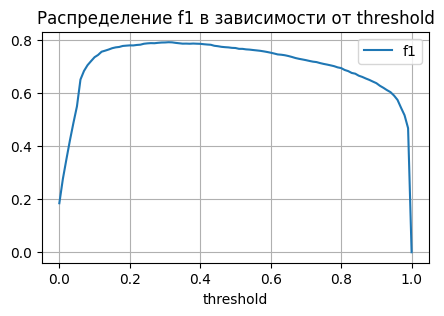

f1_max = 0.7909 при threshold = 0.31


In [94]:
threshold(probability)

In [95]:
best_results_collector(model           = 'LightGBM', 
                       coding          = 'TF-IDF', 
                       hyperparameters = 'lr = 0.1, depth = 5, iterations = 1145 и threshold = 0.31', 
                       f1              = 0.7909)

#### Bert

In [96]:
%%time
# расчёт f1 на несбалансированной и сбалансированной выборке
for cw in notebook.tqdm((None, 'balanced')):
    f1 = lgb_func(X_train_bert, Y_train, X_valid_bert, Y_valid, class_weight=cw, learning_rate=0.5)

    print(colored(f'f1 = {f1:.4} при class_weight = {cw}\n', 'red', attrs=["bold"]))

  0%|          | 0/2 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.259668
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.242863
[3]	valid_0's binary_logloss: 0.233399
[4]	valid_0's binary_logloss: 0.226288
[5]	valid_0's binary_logloss: 0.222455
[6]	valid_0's binary_logloss: 0.221677
[7]	valid_0's binary_logloss: 0.222239
[8]	valid_0's binary_logloss: 0.224091
[9]	valid_0's binary_logloss: 0.226636
[10]	valid_0's binary_logloss: 0.230987
[11]	valid_0's binary_logloss: 0.234908
[12]	valid_0's binary_logloss: 0.238685
[13]	valid_0's binary_logloss: 0.243671
[14]	valid_0's binary_logloss: 0.248013
[15]	valid_0's binary_logloss: 0.253259
[16]	valid_0's binary_logloss: 0.258559
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.221677
f1 = 0.5755 при class_weight = None

[LightGBM] [Warning] Unknown parameter: class_weight
[1]	valid_0's binary_logloss: 0.259668
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.242863
[3]	v

Результат не зависит от балансировки. Используем далее выборки по умолчанию без балансировки.

In [97]:
%%time
# расчёт f1 в зависимости от глубины дерева
for d in notebook.tqdm(range(1,15)):
    f1 = lgb_func(X_train_bert, Y_train, X_valid_bert, Y_valid, max_depth=d, learning_rate=0.5)


    print(colored(f'f1 = {f1:.4} при depth = {d}\n', 'red', attrs=["bold"]))

  0%|          | 0/14 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.302256
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.284941
[3]	valid_0's binary_logloss: 0.270768
[4]	valid_0's binary_logloss: 0.259658
[5]	valid_0's binary_logloss: 0.249826
[6]	valid_0's binary_logloss: 0.24188
[7]	valid_0's binary_logloss: 0.237635
[8]	valid_0's binary_logloss: 0.233651
[9]	valid_0's binary_logloss: 0.230255
[10]	valid_0's binary_logloss: 0.226455
[11]	valid_0's binary_logloss: 0.222678
[12]	valid_0's binary_logloss: 0.219809
[13]	valid_0's binary_logloss: 0.217305
[14]	valid_0's binary_logloss: 0.214724
[15]	valid_0's binary_logloss: 0.212474
[16]	valid_0's binary_logloss: 0.210014
[17]	valid_0's binary_logloss: 0.207818
[18]	valid_0's binary_logloss: 0.205552
[19]	valid_0's binary_logloss: 0.20383
[20]	valid_0's binary_logloss: 0.202121
[21]	valid_0's binary_logloss: 0.200269
[22]	valid_0's binary_logloss: 0.19892
[23]	valid_0's binary_logloss: 0.197339
[24]	valid_0's binary_logloss: 

[211]	valid_0's binary_logloss: 0.151842
[212]	valid_0's binary_logloss: 0.151798
[213]	valid_0's binary_logloss: 0.151712
[214]	valid_0's binary_logloss: 0.151612
[215]	valid_0's binary_logloss: 0.15163
[216]	valid_0's binary_logloss: 0.151608
[217]	valid_0's binary_logloss: 0.15155
[218]	valid_0's binary_logloss: 0.151584
[219]	valid_0's binary_logloss: 0.151573
[220]	valid_0's binary_logloss: 0.15151
[221]	valid_0's binary_logloss: 0.151469
[222]	valid_0's binary_logloss: 0.151469
[223]	valid_0's binary_logloss: 0.151417
[224]	valid_0's binary_logloss: 0.15134
[225]	valid_0's binary_logloss: 0.151219
[226]	valid_0's binary_logloss: 0.151204
[227]	valid_0's binary_logloss: 0.151171
[228]	valid_0's binary_logloss: 0.151114
[229]	valid_0's binary_logloss: 0.151046
[230]	valid_0's binary_logloss: 0.151013
[231]	valid_0's binary_logloss: 0.150982
[232]	valid_0's binary_logloss: 0.150975
[233]	valid_0's binary_logloss: 0.151007
[234]	valid_0's binary_logloss: 0.150963
[235]	valid_0's bina

[412]	valid_0's binary_logloss: 0.145919
[413]	valid_0's binary_logloss: 0.145832
[414]	valid_0's binary_logloss: 0.14583
[415]	valid_0's binary_logloss: 0.14582
[416]	valid_0's binary_logloss: 0.145835
[417]	valid_0's binary_logloss: 0.145765
[418]	valid_0's binary_logloss: 0.145767
[419]	valid_0's binary_logloss: 0.145753
[420]	valid_0's binary_logloss: 0.145746
[421]	valid_0's binary_logloss: 0.145738
[422]	valid_0's binary_logloss: 0.145721
[423]	valid_0's binary_logloss: 0.145648
[424]	valid_0's binary_logloss: 0.145631
[425]	valid_0's binary_logloss: 0.145573
[426]	valid_0's binary_logloss: 0.145541
[427]	valid_0's binary_logloss: 0.14546
[428]	valid_0's binary_logloss: 0.145443
[429]	valid_0's binary_logloss: 0.145434
[430]	valid_0's binary_logloss: 0.145437
[431]	valid_0's binary_logloss: 0.14546
[432]	valid_0's binary_logloss: 0.145446
[433]	valid_0's binary_logloss: 0.145484
[434]	valid_0's binary_logloss: 0.145473
[435]	valid_0's binary_logloss: 0.145482
[436]	valid_0's bina

[613]	valid_0's binary_logloss: 0.143185
[614]	valid_0's binary_logloss: 0.143122
[615]	valid_0's binary_logloss: 0.143109
[616]	valid_0's binary_logloss: 0.143095
[617]	valid_0's binary_logloss: 0.143061
[618]	valid_0's binary_logloss: 0.143088
[619]	valid_0's binary_logloss: 0.143082
[620]	valid_0's binary_logloss: 0.143057
[621]	valid_0's binary_logloss: 0.143064
[622]	valid_0's binary_logloss: 0.143033
[623]	valid_0's binary_logloss: 0.143024
[624]	valid_0's binary_logloss: 0.143062
[625]	valid_0's binary_logloss: 0.143013
[626]	valid_0's binary_logloss: 0.143017
[627]	valid_0's binary_logloss: 0.142947
[628]	valid_0's binary_logloss: 0.142939
[629]	valid_0's binary_logloss: 0.142961
[630]	valid_0's binary_logloss: 0.142934
[631]	valid_0's binary_logloss: 0.142931
[632]	valid_0's binary_logloss: 0.142922
[633]	valid_0's binary_logloss: 0.14292
[634]	valid_0's binary_logloss: 0.142913
[635]	valid_0's binary_logloss: 0.142886
[636]	valid_0's binary_logloss: 0.142937
[637]	valid_0's b

[127]	valid_0's binary_logloss: 0.153397
[128]	valid_0's binary_logloss: 0.153401
[129]	valid_0's binary_logloss: 0.153403
[130]	valid_0's binary_logloss: 0.153284
[131]	valid_0's binary_logloss: 0.153194
[132]	valid_0's binary_logloss: 0.153047
[133]	valid_0's binary_logloss: 0.153055
[134]	valid_0's binary_logloss: 0.152915
[135]	valid_0's binary_logloss: 0.152837
[136]	valid_0's binary_logloss: 0.152818
[137]	valid_0's binary_logloss: 0.15273
[138]	valid_0's binary_logloss: 0.152644
[139]	valid_0's binary_logloss: 0.152597
[140]	valid_0's binary_logloss: 0.152488
[141]	valid_0's binary_logloss: 0.152357
[142]	valid_0's binary_logloss: 0.152339
[143]	valid_0's binary_logloss: 0.152294
[144]	valid_0's binary_logloss: 0.152252
[145]	valid_0's binary_logloss: 0.152274
[146]	valid_0's binary_logloss: 0.1522
[147]	valid_0's binary_logloss: 0.152136
[148]	valid_0's binary_logloss: 0.152188
[149]	valid_0's binary_logloss: 0.152165
[150]	valid_0's binary_logloss: 0.152205
[151]	valid_0's bin

[18]	valid_0's binary_logloss: 0.173246
[19]	valid_0's binary_logloss: 0.173114
[20]	valid_0's binary_logloss: 0.17244
[21]	valid_0's binary_logloss: 0.172235
[22]	valid_0's binary_logloss: 0.171984
[23]	valid_0's binary_logloss: 0.17188
[24]	valid_0's binary_logloss: 0.172592
[25]	valid_0's binary_logloss: 0.17291
[26]	valid_0's binary_logloss: 0.17297
[27]	valid_0's binary_logloss: 0.173685
[28]	valid_0's binary_logloss: 0.172665
[29]	valid_0's binary_logloss: 0.173511
[30]	valid_0's binary_logloss: 0.173278
[31]	valid_0's binary_logloss: 0.173303
[32]	valid_0's binary_logloss: 0.173506
[33]	valid_0's binary_logloss: 0.173334
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.17188
f1 = 0.6452 при depth = 5

[1]	valid_0's binary_logloss: 0.248901
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.227575
[3]	valid_0's binary_logloss: 0.213515
[4]	valid_0's binary_logloss: 0.203434
[5]	valid_0's binary_logloss: 0.196571
[6]	val

[8]	valid_0's binary_logloss: 0.216676
[9]	valid_0's binary_logloss: 0.218842
[10]	valid_0's binary_logloss: 0.220999
[11]	valid_0's binary_logloss: 0.224293
[12]	valid_0's binary_logloss: 0.22705
[13]	valid_0's binary_logloss: 0.230937
[14]	valid_0's binary_logloss: 0.234729
[15]	valid_0's binary_logloss: 0.238898
[16]	valid_0's binary_logloss: 0.242413
[17]	valid_0's binary_logloss: 0.246439
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.216653
f1 = 0.584 при depth = 13

[1]	valid_0's binary_logloss: 0.259116
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.243838
[3]	valid_0's binary_logloss: 0.234728
[4]	valid_0's binary_logloss: 0.227566
[5]	valid_0's binary_logloss: 0.224293
[6]	valid_0's binary_logloss: 0.221286
[7]	valid_0's binary_logloss: 0.221267
[8]	valid_0's binary_logloss: 0.222765
[9]	valid_0's binary_logloss: 0.22575
[10]	valid_0's binary_logloss: 0.22798
[11]	valid_0's binary_logloss: 0.231827
[12]	valid_0

Лучший результат f1 = 0.7064 при depth = 1, итерация 683, learning_rate = 0.5.

In [98]:
%%time
# расчёт f1 в зависимости от learning_rate
for lr_ in notebook.tqdm((0.1, 0.01)):
    f1 = lgb_func(X_train_bert, Y_train, X_valid_bert, Y_valid, max_depth=1, learning_rate=lr_)

    print(colored(f'f1 = {f1:.4} при learning_rate = {lr_}\n', 'red', attrs=["bold"]))

  0%|          | 0/2 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.321407
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.31532
[3]	valid_0's binary_logloss: 0.309579
[4]	valid_0's binary_logloss: 0.304366
[5]	valid_0's binary_logloss: 0.299547
[6]	valid_0's binary_logloss: 0.295067
[7]	valid_0's binary_logloss: 0.290885
[8]	valid_0's binary_logloss: 0.28688
[9]	valid_0's binary_logloss: 0.283446
[10]	valid_0's binary_logloss: 0.280118
[11]	valid_0's binary_logloss: 0.276995
[12]	valid_0's binary_logloss: 0.274084
[13]	valid_0's binary_logloss: 0.271311
[14]	valid_0's binary_logloss: 0.268648
[15]	valid_0's binary_logloss: 0.266212
[16]	valid_0's binary_logloss: 0.264013
[17]	valid_0's binary_logloss: 0.261898
[18]	valid_0's binary_logloss: 0.259844
[19]	valid_0's binary_logloss: 0.257917
[20]	valid_0's binary_logloss: 0.25592
[21]	valid_0's binary_logloss: 0.254033
[22]	valid_0's binary_logloss: 0.25217
[23]	valid_0's binary_logloss: 0.250502
[24]	valid_0's binary_logloss: 0

[206]	valid_0's binary_logloss: 0.173557
[207]	valid_0's binary_logloss: 0.173424
[208]	valid_0's binary_logloss: 0.1733
[209]	valid_0's binary_logloss: 0.173177
[210]	valid_0's binary_logloss: 0.173054
[211]	valid_0's binary_logloss: 0.172904
[212]	valid_0's binary_logloss: 0.172808
[213]	valid_0's binary_logloss: 0.172727
[214]	valid_0's binary_logloss: 0.172622
[215]	valid_0's binary_logloss: 0.172494
[216]	valid_0's binary_logloss: 0.172333
[217]	valid_0's binary_logloss: 0.172256
[218]	valid_0's binary_logloss: 0.172163
[219]	valid_0's binary_logloss: 0.17204
[220]	valid_0's binary_logloss: 0.171965
[221]	valid_0's binary_logloss: 0.171884
[222]	valid_0's binary_logloss: 0.171763
[223]	valid_0's binary_logloss: 0.171636
[224]	valid_0's binary_logloss: 0.171506
[225]	valid_0's binary_logloss: 0.17136
[226]	valid_0's binary_logloss: 0.17126
[227]	valid_0's binary_logloss: 0.171164
[228]	valid_0's binary_logloss: 0.171049
[229]	valid_0's binary_logloss: 0.170935
[230]	valid_0's binar

[417]	valid_0's binary_logloss: 0.158368
[418]	valid_0's binary_logloss: 0.158313
[419]	valid_0's binary_logloss: 0.158279
[420]	valid_0's binary_logloss: 0.158233
[421]	valid_0's binary_logloss: 0.158186
[422]	valid_0's binary_logloss: 0.158137
[423]	valid_0's binary_logloss: 0.158091
[424]	valid_0's binary_logloss: 0.158051
[425]	valid_0's binary_logloss: 0.158019
[426]	valid_0's binary_logloss: 0.157987
[427]	valid_0's binary_logloss: 0.157935
[428]	valid_0's binary_logloss: 0.157897
[429]	valid_0's binary_logloss: 0.15787
[430]	valid_0's binary_logloss: 0.157829
[431]	valid_0's binary_logloss: 0.157781
[432]	valid_0's binary_logloss: 0.157706
[433]	valid_0's binary_logloss: 0.157677
[434]	valid_0's binary_logloss: 0.157632
[435]	valid_0's binary_logloss: 0.157609
[436]	valid_0's binary_logloss: 0.157563
[437]	valid_0's binary_logloss: 0.157528
[438]	valid_0's binary_logloss: 0.15749
[439]	valid_0's binary_logloss: 0.157475
[440]	valid_0's binary_logloss: 0.157414
[441]	valid_0's bi

[619]	valid_0's binary_logloss: 0.152724
[620]	valid_0's binary_logloss: 0.152712
[621]	valid_0's binary_logloss: 0.152696
[622]	valid_0's binary_logloss: 0.152679
[623]	valid_0's binary_logloss: 0.152651
[624]	valid_0's binary_logloss: 0.152624
[625]	valid_0's binary_logloss: 0.152596
[626]	valid_0's binary_logloss: 0.152564
[627]	valid_0's binary_logloss: 0.152538
[628]	valid_0's binary_logloss: 0.152511
[629]	valid_0's binary_logloss: 0.152485
[630]	valid_0's binary_logloss: 0.152462
[631]	valid_0's binary_logloss: 0.152452
[632]	valid_0's binary_logloss: 0.152432
[633]	valid_0's binary_logloss: 0.152415
[634]	valid_0's binary_logloss: 0.152398
[635]	valid_0's binary_logloss: 0.152385
[636]	valid_0's binary_logloss: 0.152365
[637]	valid_0's binary_logloss: 0.152338
[638]	valid_0's binary_logloss: 0.152313
[639]	valid_0's binary_logloss: 0.152288
[640]	valid_0's binary_logloss: 0.152264
[641]	valid_0's binary_logloss: 0.152239
[642]	valid_0's binary_logloss: 0.152225
[643]	valid_0's 

[830]	valid_0's binary_logloss: 0.149255
[831]	valid_0's binary_logloss: 0.149248
[832]	valid_0's binary_logloss: 0.149238
[833]	valid_0's binary_logloss: 0.149225
[834]	valid_0's binary_logloss: 0.14922
[835]	valid_0's binary_logloss: 0.149219
[836]	valid_0's binary_logloss: 0.149217
[837]	valid_0's binary_logloss: 0.149199
[838]	valid_0's binary_logloss: 0.14919
[839]	valid_0's binary_logloss: 0.149183
[840]	valid_0's binary_logloss: 0.14916
[841]	valid_0's binary_logloss: 0.14915
[842]	valid_0's binary_logloss: 0.149135
[843]	valid_0's binary_logloss: 0.149106
[844]	valid_0's binary_logloss: 0.149103
[845]	valid_0's binary_logloss: 0.14909
[846]	valid_0's binary_logloss: 0.149078
[847]	valid_0's binary_logloss: 0.149062
[848]	valid_0's binary_logloss: 0.149051
[849]	valid_0's binary_logloss: 0.149045
[850]	valid_0's binary_logloss: 0.149024
[851]	valid_0's binary_logloss: 0.149015
[852]	valid_0's binary_logloss: 0.149006
[853]	valid_0's binary_logloss: 0.149001
[854]	valid_0's binar

[1036]	valid_0's binary_logloss: 0.147178
[1037]	valid_0's binary_logloss: 0.147167
[1038]	valid_0's binary_logloss: 0.147159
[1039]	valid_0's binary_logloss: 0.147141
[1040]	valid_0's binary_logloss: 0.147133
[1041]	valid_0's binary_logloss: 0.147143
[1042]	valid_0's binary_logloss: 0.147138
[1043]	valid_0's binary_logloss: 0.147128
[1044]	valid_0's binary_logloss: 0.147113
[1045]	valid_0's binary_logloss: 0.1471
[1046]	valid_0's binary_logloss: 0.147092
[1047]	valid_0's binary_logloss: 0.147082
[1048]	valid_0's binary_logloss: 0.147071
[1049]	valid_0's binary_logloss: 0.147067
[1050]	valid_0's binary_logloss: 0.147052
[1051]	valid_0's binary_logloss: 0.14704
[1052]	valid_0's binary_logloss: 0.147028
[1053]	valid_0's binary_logloss: 0.147015
[1054]	valid_0's binary_logloss: 0.147003
[1055]	valid_0's binary_logloss: 0.146985
[1056]	valid_0's binary_logloss: 0.146976
[1057]	valid_0's binary_logloss: 0.146967
[1058]	valid_0's binary_logloss: 0.146964
[1059]	valid_0's binary_logloss: 0.14

[1234]	valid_0's binary_logloss: 0.145626
[1235]	valid_0's binary_logloss: 0.145619
[1236]	valid_0's binary_logloss: 0.14561
[1237]	valid_0's binary_logloss: 0.145595
[1238]	valid_0's binary_logloss: 0.145595
[1239]	valid_0's binary_logloss: 0.145597
[1240]	valid_0's binary_logloss: 0.145598
[1241]	valid_0's binary_logloss: 0.145589
[1242]	valid_0's binary_logloss: 0.14559
[1243]	valid_0's binary_logloss: 0.145585
[1244]	valid_0's binary_logloss: 0.145568
[1245]	valid_0's binary_logloss: 0.14557
[1246]	valid_0's binary_logloss: 0.145562
[1247]	valid_0's binary_logloss: 0.145553
[1248]	valid_0's binary_logloss: 0.145542
[1249]	valid_0's binary_logloss: 0.145536
[1250]	valid_0's binary_logloss: 0.145527
[1251]	valid_0's binary_logloss: 0.145521
[1252]	valid_0's binary_logloss: 0.145526
[1253]	valid_0's binary_logloss: 0.145524
[1254]	valid_0's binary_logloss: 0.145521
[1255]	valid_0's binary_logloss: 0.145517
[1256]	valid_0's binary_logloss: 0.145513
[1257]	valid_0's binary_logloss: 0.14

[1432]	valid_0's binary_logloss: 0.144484
[1433]	valid_0's binary_logloss: 0.144476
[1434]	valid_0's binary_logloss: 0.144462
[1435]	valid_0's binary_logloss: 0.144457
[1436]	valid_0's binary_logloss: 0.144443
[1437]	valid_0's binary_logloss: 0.144437
[1438]	valid_0's binary_logloss: 0.144427
[1439]	valid_0's binary_logloss: 0.14442
[1440]	valid_0's binary_logloss: 0.144417
[1441]	valid_0's binary_logloss: 0.144419
[1442]	valid_0's binary_logloss: 0.144413
[1443]	valid_0's binary_logloss: 0.144407
[1444]	valid_0's binary_logloss: 0.144398
[1445]	valid_0's binary_logloss: 0.144385
[1446]	valid_0's binary_logloss: 0.144376
[1447]	valid_0's binary_logloss: 0.144364
[1448]	valid_0's binary_logloss: 0.144349
[1449]	valid_0's binary_logloss: 0.144343
[1450]	valid_0's binary_logloss: 0.144334
[1451]	valid_0's binary_logloss: 0.144327
[1452]	valid_0's binary_logloss: 0.144325
[1453]	valid_0's binary_logloss: 0.144327
[1454]	valid_0's binary_logloss: 0.144323
[1455]	valid_0's binary_logloss: 0.

[1643]	valid_0's binary_logloss: 0.143412
[1644]	valid_0's binary_logloss: 0.143409
[1645]	valid_0's binary_logloss: 0.143397
[1646]	valid_0's binary_logloss: 0.143394
[1647]	valid_0's binary_logloss: 0.143388
[1648]	valid_0's binary_logloss: 0.143383
[1649]	valid_0's binary_logloss: 0.143382
[1650]	valid_0's binary_logloss: 0.14338
[1651]	valid_0's binary_logloss: 0.143374
[1652]	valid_0's binary_logloss: 0.143374
[1653]	valid_0's binary_logloss: 0.143362
[1654]	valid_0's binary_logloss: 0.143357
[1655]	valid_0's binary_logloss: 0.14335
[1656]	valid_0's binary_logloss: 0.143343
[1657]	valid_0's binary_logloss: 0.143342
[1658]	valid_0's binary_logloss: 0.143345
[1659]	valid_0's binary_logloss: 0.143346
[1660]	valid_0's binary_logloss: 0.143335
[1661]	valid_0's binary_logloss: 0.143338
[1662]	valid_0's binary_logloss: 0.143335
[1663]	valid_0's binary_logloss: 0.143332
[1664]	valid_0's binary_logloss: 0.143325
[1665]	valid_0's binary_logloss: 0.143322
[1666]	valid_0's binary_logloss: 0.1

[1841]	valid_0's binary_logloss: 0.142555
[1842]	valid_0's binary_logloss: 0.142548
[1843]	valid_0's binary_logloss: 0.142545
[1844]	valid_0's binary_logloss: 0.142541
[1845]	valid_0's binary_logloss: 0.142528
[1846]	valid_0's binary_logloss: 0.14252
[1847]	valid_0's binary_logloss: 0.142513
[1848]	valid_0's binary_logloss: 0.142514
[1849]	valid_0's binary_logloss: 0.142505
[1850]	valid_0's binary_logloss: 0.1425
[1851]	valid_0's binary_logloss: 0.142505
[1852]	valid_0's binary_logloss: 0.142504
[1853]	valid_0's binary_logloss: 0.142497
[1854]	valid_0's binary_logloss: 0.142483
[1855]	valid_0's binary_logloss: 0.142488
[1856]	valid_0's binary_logloss: 0.142485
[1857]	valid_0's binary_logloss: 0.142484
[1858]	valid_0's binary_logloss: 0.142482
[1859]	valid_0's binary_logloss: 0.142478
[1860]	valid_0's binary_logloss: 0.142484
[1861]	valid_0's binary_logloss: 0.142482
[1862]	valid_0's binary_logloss: 0.142468
[1863]	valid_0's binary_logloss: 0.142464
[1864]	valid_0's binary_logloss: 0.14

[2039]	valid_0's binary_logloss: 0.141793
[2040]	valid_0's binary_logloss: 0.1418
[2041]	valid_0's binary_logloss: 0.141794
[2042]	valid_0's binary_logloss: 0.141803
[2043]	valid_0's binary_logloss: 0.141803
[2044]	valid_0's binary_logloss: 0.141794
[2045]	valid_0's binary_logloss: 0.141791
Early stopping, best iteration is:
[2035]	valid_0's binary_logloss: 0.141791
f1 = 0.6959 при learning_rate = 0.1

[1]	valid_0's binary_logloss: 0.327846
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.327151
[3]	valid_0's binary_logloss: 0.326427
[4]	valid_0's binary_logloss: 0.32576
[5]	valid_0's binary_logloss: 0.325061
[6]	valid_0's binary_logloss: 0.324419
[7]	valid_0's binary_logloss: 0.323767
[8]	valid_0's binary_logloss: 0.323097
[9]	valid_0's binary_logloss: 0.322477
[10]	valid_0's binary_logloss: 0.321851
[11]	valid_0's binary_logloss: 0.321208
[12]	valid_0's binary_logloss: 0.320588
[13]	valid_0's binary_logloss: 0.319965
[14]	valid_0's binary_l

[197]	valid_0's binary_logloss: 0.258449
[198]	valid_0's binary_logloss: 0.258251
[199]	valid_0's binary_logloss: 0.258065
[200]	valid_0's binary_logloss: 0.257865
[201]	valid_0's binary_logloss: 0.257681
[202]	valid_0's binary_logloss: 0.257493
[203]	valid_0's binary_logloss: 0.257304
[204]	valid_0's binary_logloss: 0.257124
[205]	valid_0's binary_logloss: 0.25695
[206]	valid_0's binary_logloss: 0.256771
[207]	valid_0's binary_logloss: 0.256581
[208]	valid_0's binary_logloss: 0.256381
[209]	valid_0's binary_logloss: 0.25619
[210]	valid_0's binary_logloss: 0.25601
[211]	valid_0's binary_logloss: 0.255831
[212]	valid_0's binary_logloss: 0.255656
[213]	valid_0's binary_logloss: 0.255481
[214]	valid_0's binary_logloss: 0.255307
[215]	valid_0's binary_logloss: 0.255128
[216]	valid_0's binary_logloss: 0.254949
[217]	valid_0's binary_logloss: 0.254777
[218]	valid_0's binary_logloss: 0.254613
[219]	valid_0's binary_logloss: 0.254422
[220]	valid_0's binary_logloss: 0.254243
[221]	valid_0's bin

[411]	valid_0's binary_logloss: 0.229854
[412]	valid_0's binary_logloss: 0.229759
[413]	valid_0's binary_logloss: 0.229664
[414]	valid_0's binary_logloss: 0.229573
[415]	valid_0's binary_logloss: 0.229477
[416]	valid_0's binary_logloss: 0.229385
[417]	valid_0's binary_logloss: 0.22929
[418]	valid_0's binary_logloss: 0.229191
[419]	valid_0's binary_logloss: 0.229097
[420]	valid_0's binary_logloss: 0.229002
[421]	valid_0's binary_logloss: 0.228914
[422]	valid_0's binary_logloss: 0.228826
[423]	valid_0's binary_logloss: 0.228733
[424]	valid_0's binary_logloss: 0.228642
[425]	valid_0's binary_logloss: 0.228549
[426]	valid_0's binary_logloss: 0.228454
[427]	valid_0's binary_logloss: 0.228359
[428]	valid_0's binary_logloss: 0.228276
[429]	valid_0's binary_logloss: 0.228182
[430]	valid_0's binary_logloss: 0.228092
[431]	valid_0's binary_logloss: 0.227999
[432]	valid_0's binary_logloss: 0.227903
[433]	valid_0's binary_logloss: 0.227812
[434]	valid_0's binary_logloss: 0.227721
[435]	valid_0's b

[624]	valid_0's binary_logloss: 0.213336
[625]	valid_0's binary_logloss: 0.213273
[626]	valid_0's binary_logloss: 0.213207
[627]	valid_0's binary_logloss: 0.213142
[628]	valid_0's binary_logloss: 0.213081
[629]	valid_0's binary_logloss: 0.213026
[630]	valid_0's binary_logloss: 0.21297
[631]	valid_0's binary_logloss: 0.212907
[632]	valid_0's binary_logloss: 0.212843
[633]	valid_0's binary_logloss: 0.212778
[634]	valid_0's binary_logloss: 0.212714
[635]	valid_0's binary_logloss: 0.212649
[636]	valid_0's binary_logloss: 0.212593
[637]	valid_0's binary_logloss: 0.212532
[638]	valid_0's binary_logloss: 0.212473
[639]	valid_0's binary_logloss: 0.212409
[640]	valid_0's binary_logloss: 0.21235
[641]	valid_0's binary_logloss: 0.212292
[642]	valid_0's binary_logloss: 0.212232
[643]	valid_0's binary_logloss: 0.212166
[644]	valid_0's binary_logloss: 0.212109
[645]	valid_0's binary_logloss: 0.212043
[646]	valid_0's binary_logloss: 0.211986
[647]	valid_0's binary_logloss: 0.211922
[648]	valid_0's bi

[833]	valid_0's binary_logloss: 0.2024
[834]	valid_0's binary_logloss: 0.202363
[835]	valid_0's binary_logloss: 0.202319
[836]	valid_0's binary_logloss: 0.202272
[837]	valid_0's binary_logloss: 0.20223
[838]	valid_0's binary_logloss: 0.202186
[839]	valid_0's binary_logloss: 0.202142
[840]	valid_0's binary_logloss: 0.202104
[841]	valid_0's binary_logloss: 0.202064
[842]	valid_0's binary_logloss: 0.20202
[843]	valid_0's binary_logloss: 0.20198
[844]	valid_0's binary_logloss: 0.201941
[845]	valid_0's binary_logloss: 0.2019
[846]	valid_0's binary_logloss: 0.201852
[847]	valid_0's binary_logloss: 0.201815
[848]	valid_0's binary_logloss: 0.20177
[849]	valid_0's binary_logloss: 0.201724
[850]	valid_0's binary_logloss: 0.201681
[851]	valid_0's binary_logloss: 0.201643
[852]	valid_0's binary_logloss: 0.201606
[853]	valid_0's binary_logloss: 0.20156
[854]	valid_0's binary_logloss: 0.201518
[855]	valid_0's binary_logloss: 0.201476
[856]	valid_0's binary_logloss: 0.201432
[857]	valid_0's binary_lo

[1045]	valid_0's binary_logloss: 0.194527
[1046]	valid_0's binary_logloss: 0.194496
[1047]	valid_0's binary_logloss: 0.194463
[1048]	valid_0's binary_logloss: 0.194433
[1049]	valid_0's binary_logloss: 0.194403
[1050]	valid_0's binary_logloss: 0.194375
[1051]	valid_0's binary_logloss: 0.194345
[1052]	valid_0's binary_logloss: 0.194319
[1053]	valid_0's binary_logloss: 0.194285
[1054]	valid_0's binary_logloss: 0.194253
[1055]	valid_0's binary_logloss: 0.194223
[1056]	valid_0's binary_logloss: 0.194189
[1057]	valid_0's binary_logloss: 0.194157
[1058]	valid_0's binary_logloss: 0.194128
[1059]	valid_0's binary_logloss: 0.194092
[1060]	valid_0's binary_logloss: 0.194064
[1061]	valid_0's binary_logloss: 0.194036
[1062]	valid_0's binary_logloss: 0.194003
[1063]	valid_0's binary_logloss: 0.193969
[1064]	valid_0's binary_logloss: 0.193941
[1065]	valid_0's binary_logloss: 0.193909
[1066]	valid_0's binary_logloss: 0.193879
[1067]	valid_0's binary_logloss: 0.193846
[1068]	valid_0's binary_logloss: 0

[1244]	valid_0's binary_logloss: 0.188831
[1245]	valid_0's binary_logloss: 0.188808
[1246]	valid_0's binary_logloss: 0.18878
[1247]	valid_0's binary_logloss: 0.188751
[1248]	valid_0's binary_logloss: 0.188725
[1249]	valid_0's binary_logloss: 0.188701
[1250]	valid_0's binary_logloss: 0.188678
[1251]	valid_0's binary_logloss: 0.188652
[1252]	valid_0's binary_logloss: 0.188627
[1253]	valid_0's binary_logloss: 0.188604
[1254]	valid_0's binary_logloss: 0.188579
[1255]	valid_0's binary_logloss: 0.188553
[1256]	valid_0's binary_logloss: 0.188526
[1257]	valid_0's binary_logloss: 0.188503
[1258]	valid_0's binary_logloss: 0.188475
[1259]	valid_0's binary_logloss: 0.188446
[1260]	valid_0's binary_logloss: 0.188426
[1261]	valid_0's binary_logloss: 0.1884
[1262]	valid_0's binary_logloss: 0.188379
[1263]	valid_0's binary_logloss: 0.188356
[1264]	valid_0's binary_logloss: 0.188333
[1265]	valid_0's binary_logloss: 0.188306
[1266]	valid_0's binary_logloss: 0.18828
[1267]	valid_0's binary_logloss: 0.188

[1442]	valid_0's binary_logloss: 0.18427
[1443]	valid_0's binary_logloss: 0.184251
[1444]	valid_0's binary_logloss: 0.184227
[1445]	valid_0's binary_logloss: 0.184208
[1446]	valid_0's binary_logloss: 0.184188
[1447]	valid_0's binary_logloss: 0.184166
[1448]	valid_0's binary_logloss: 0.184147
[1449]	valid_0's binary_logloss: 0.184127
[1450]	valid_0's binary_logloss: 0.184112
[1451]	valid_0's binary_logloss: 0.184086
[1452]	valid_0's binary_logloss: 0.184068
[1453]	valid_0's binary_logloss: 0.184047
[1454]	valid_0's binary_logloss: 0.18403
[1455]	valid_0's binary_logloss: 0.184006
[1456]	valid_0's binary_logloss: 0.183984
[1457]	valid_0's binary_logloss: 0.183966
[1458]	valid_0's binary_logloss: 0.18394
[1459]	valid_0's binary_logloss: 0.183919
[1460]	valid_0's binary_logloss: 0.183899
[1461]	valid_0's binary_logloss: 0.183881
[1462]	valid_0's binary_logloss: 0.18386
[1463]	valid_0's binary_logloss: 0.183841
[1464]	valid_0's binary_logloss: 0.183821
[1465]	valid_0's binary_logloss: 0.183

[1641]	valid_0's binary_logloss: 0.180468
[1642]	valid_0's binary_logloss: 0.180446
[1643]	valid_0's binary_logloss: 0.180431
[1644]	valid_0's binary_logloss: 0.180414
[1645]	valid_0's binary_logloss: 0.180398
[1646]	valid_0's binary_logloss: 0.180383
[1647]	valid_0's binary_logloss: 0.180361
[1648]	valid_0's binary_logloss: 0.180344
[1649]	valid_0's binary_logloss: 0.180328
[1650]	valid_0's binary_logloss: 0.180313
[1651]	valid_0's binary_logloss: 0.180293
[1652]	valid_0's binary_logloss: 0.180278
[1653]	valid_0's binary_logloss: 0.180262
[1654]	valid_0's binary_logloss: 0.180246
[1655]	valid_0's binary_logloss: 0.180226
[1656]	valid_0's binary_logloss: 0.18021
[1657]	valid_0's binary_logloss: 0.180195
[1658]	valid_0's binary_logloss: 0.180181
[1659]	valid_0's binary_logloss: 0.180168
[1660]	valid_0's binary_logloss: 0.180148
[1661]	valid_0's binary_logloss: 0.180135
[1662]	valid_0's binary_logloss: 0.180115
[1663]	valid_0's binary_logloss: 0.180099
[1664]	valid_0's binary_logloss: 0.

[1839]	valid_0's binary_logloss: 0.177272
[1840]	valid_0's binary_logloss: 0.177258
[1841]	valid_0's binary_logloss: 0.177242
[1842]	valid_0's binary_logloss: 0.177231
[1843]	valid_0's binary_logloss: 0.177217
[1844]	valid_0's binary_logloss: 0.177205
[1845]	valid_0's binary_logloss: 0.177195
[1846]	valid_0's binary_logloss: 0.177179
[1847]	valid_0's binary_logloss: 0.177165
[1848]	valid_0's binary_logloss: 0.177149
[1849]	valid_0's binary_logloss: 0.177134
[1850]	valid_0's binary_logloss: 0.177122
[1851]	valid_0's binary_logloss: 0.177104
[1852]	valid_0's binary_logloss: 0.177094
[1853]	valid_0's binary_logloss: 0.177078
[1854]	valid_0's binary_logloss: 0.177059
[1855]	valid_0's binary_logloss: 0.177041
[1856]	valid_0's binary_logloss: 0.177028
[1857]	valid_0's binary_logloss: 0.17701
[1858]	valid_0's binary_logloss: 0.176992
[1859]	valid_0's binary_logloss: 0.176979
[1860]	valid_0's binary_logloss: 0.176967
[1861]	valid_0's binary_logloss: 0.176953
[1862]	valid_0's binary_logloss: 0.

[2040]	valid_0's binary_logloss: 0.174494
[2041]	valid_0's binary_logloss: 0.174482
[2042]	valid_0's binary_logloss: 0.17447
[2043]	valid_0's binary_logloss: 0.174456
[2044]	valid_0's binary_logloss: 0.174445
[2045]	valid_0's binary_logloss: 0.174432
[2046]	valid_0's binary_logloss: 0.174416
[2047]	valid_0's binary_logloss: 0.174402
[2048]	valid_0's binary_logloss: 0.174391
[2049]	valid_0's binary_logloss: 0.174377
[2050]	valid_0's binary_logloss: 0.174368
[2051]	valid_0's binary_logloss: 0.174356
[2052]	valid_0's binary_logloss: 0.174344
[2053]	valid_0's binary_logloss: 0.174332
[2054]	valid_0's binary_logloss: 0.174318
[2055]	valid_0's binary_logloss: 0.174307
[2056]	valid_0's binary_logloss: 0.174291
[2057]	valid_0's binary_logloss: 0.174279
[2058]	valid_0's binary_logloss: 0.174265
[2059]	valid_0's binary_logloss: 0.174254
[2060]	valid_0's binary_logloss: 0.17424
[2061]	valid_0's binary_logloss: 0.174229
[2062]	valid_0's binary_logloss: 0.174213
[2063]	valid_0's binary_logloss: 0.1

[2237]	valid_0's binary_logloss: 0.172134
[2238]	valid_0's binary_logloss: 0.172124
[2239]	valid_0's binary_logloss: 0.172113
[2240]	valid_0's binary_logloss: 0.172103
[2241]	valid_0's binary_logloss: 0.172095
[2242]	valid_0's binary_logloss: 0.172084
[2243]	valid_0's binary_logloss: 0.17207
[2244]	valid_0's binary_logloss: 0.172058
[2245]	valid_0's binary_logloss: 0.172046
[2246]	valid_0's binary_logloss: 0.172034
[2247]	valid_0's binary_logloss: 0.172024
[2248]	valid_0's binary_logloss: 0.172014
[2249]	valid_0's binary_logloss: 0.172004
[2250]	valid_0's binary_logloss: 0.171994
[2251]	valid_0's binary_logloss: 0.171984
[2252]	valid_0's binary_logloss: 0.171973
[2253]	valid_0's binary_logloss: 0.17196
[2254]	valid_0's binary_logloss: 0.171948
[2255]	valid_0's binary_logloss: 0.171937
[2256]	valid_0's binary_logloss: 0.171925
[2257]	valid_0's binary_logloss: 0.171915
[2258]	valid_0's binary_logloss: 0.171903
[2259]	valid_0's binary_logloss: 0.171895
[2260]	valid_0's binary_logloss: 0.1

[2435]	valid_0's binary_logloss: 0.170046
[2436]	valid_0's binary_logloss: 0.170035
[2437]	valid_0's binary_logloss: 0.170027
[2438]	valid_0's binary_logloss: 0.170018
[2439]	valid_0's binary_logloss: 0.170008
[2440]	valid_0's binary_logloss: 0.169998
[2441]	valid_0's binary_logloss: 0.169986
[2442]	valid_0's binary_logloss: 0.169978
[2443]	valid_0's binary_logloss: 0.169969
[2444]	valid_0's binary_logloss: 0.169959
[2445]	valid_0's binary_logloss: 0.169948
[2446]	valid_0's binary_logloss: 0.169939
[2447]	valid_0's binary_logloss: 0.169928
[2448]	valid_0's binary_logloss: 0.169918
[2449]	valid_0's binary_logloss: 0.169908
[2450]	valid_0's binary_logloss: 0.169898
[2451]	valid_0's binary_logloss: 0.169889
[2452]	valid_0's binary_logloss: 0.16988
[2453]	valid_0's binary_logloss: 0.169868
[2454]	valid_0's binary_logloss: 0.169861
[2455]	valid_0's binary_logloss: 0.169849
[2456]	valid_0's binary_logloss: 0.169842
[2457]	valid_0's binary_logloss: 0.169834
[2458]	valid_0's binary_logloss: 0.

[2633]	valid_0's binary_logloss: 0.168184
[2634]	valid_0's binary_logloss: 0.168174
[2635]	valid_0's binary_logloss: 0.168169
[2636]	valid_0's binary_logloss: 0.168159
[2637]	valid_0's binary_logloss: 0.168149
[2638]	valid_0's binary_logloss: 0.168141
[2639]	valid_0's binary_logloss: 0.16813
[2640]	valid_0's binary_logloss: 0.168123
[2641]	valid_0's binary_logloss: 0.168114
[2642]	valid_0's binary_logloss: 0.168105
[2643]	valid_0's binary_logloss: 0.168094
[2644]	valid_0's binary_logloss: 0.168082
[2645]	valid_0's binary_logloss: 0.168073
[2646]	valid_0's binary_logloss: 0.168065
[2647]	valid_0's binary_logloss: 0.168056
[2648]	valid_0's binary_logloss: 0.168049
[2649]	valid_0's binary_logloss: 0.168039
[2650]	valid_0's binary_logloss: 0.16803
[2651]	valid_0's binary_logloss: 0.168019
[2652]	valid_0's binary_logloss: 0.168011
[2653]	valid_0's binary_logloss: 0.168
[2654]	valid_0's binary_logloss: 0.167991
[2655]	valid_0's binary_logloss: 0.167979
[2656]	valid_0's binary_logloss: 0.1679

[2833]	valid_0's binary_logloss: 0.166481
[2834]	valid_0's binary_logloss: 0.166473
[2835]	valid_0's binary_logloss: 0.166465
[2836]	valid_0's binary_logloss: 0.166456
[2837]	valid_0's binary_logloss: 0.166447
[2838]	valid_0's binary_logloss: 0.166439
[2839]	valid_0's binary_logloss: 0.16643
[2840]	valid_0's binary_logloss: 0.166426
[2841]	valid_0's binary_logloss: 0.166419
[2842]	valid_0's binary_logloss: 0.166413
[2843]	valid_0's binary_logloss: 0.166405
[2844]	valid_0's binary_logloss: 0.166395
[2845]	valid_0's binary_logloss: 0.166385
[2846]	valid_0's binary_logloss: 0.166378
[2847]	valid_0's binary_logloss: 0.166368
[2848]	valid_0's binary_logloss: 0.166359
[2849]	valid_0's binary_logloss: 0.166351
[2850]	valid_0's binary_logloss: 0.166342
[2851]	valid_0's binary_logloss: 0.166335
[2852]	valid_0's binary_logloss: 0.166328
[2853]	valid_0's binary_logloss: 0.166318
[2854]	valid_0's binary_logloss: 0.166311
[2855]	valid_0's binary_logloss: 0.166303
[2856]	valid_0's binary_logloss: 0.

[3032]	valid_0's binary_logloss: 0.164964
[3033]	valid_0's binary_logloss: 0.164957
[3034]	valid_0's binary_logloss: 0.16495
[3035]	valid_0's binary_logloss: 0.16494
[3036]	valid_0's binary_logloss: 0.164934
[3037]	valid_0's binary_logloss: 0.164925
[3038]	valid_0's binary_logloss: 0.164918
[3039]	valid_0's binary_logloss: 0.164909
[3040]	valid_0's binary_logloss: 0.164902
[3041]	valid_0's binary_logloss: 0.164896
[3042]	valid_0's binary_logloss: 0.164887
[3043]	valid_0's binary_logloss: 0.16488
[3044]	valid_0's binary_logloss: 0.164871
[3045]	valid_0's binary_logloss: 0.164866
[3046]	valid_0's binary_logloss: 0.164858
[3047]	valid_0's binary_logloss: 0.164851
[3048]	valid_0's binary_logloss: 0.164843
[3049]	valid_0's binary_logloss: 0.164837
[3050]	valid_0's binary_logloss: 0.16483
[3051]	valid_0's binary_logloss: 0.164823
[3052]	valid_0's binary_logloss: 0.164815
[3053]	valid_0's binary_logloss: 0.164809
[3054]	valid_0's binary_logloss: 0.164803
[3055]	valid_0's binary_logloss: 0.164

[3234]	valid_0's binary_logloss: 0.163584
[3235]	valid_0's binary_logloss: 0.163578
[3236]	valid_0's binary_logloss: 0.163571
[3237]	valid_0's binary_logloss: 0.163564
[3238]	valid_0's binary_logloss: 0.163557
[3239]	valid_0's binary_logloss: 0.163553
[3240]	valid_0's binary_logloss: 0.163547
[3241]	valid_0's binary_logloss: 0.163542
[3242]	valid_0's binary_logloss: 0.163539
[3243]	valid_0's binary_logloss: 0.163533
[3244]	valid_0's binary_logloss: 0.163525
[3245]	valid_0's binary_logloss: 0.163518
[3246]	valid_0's binary_logloss: 0.163512
[3247]	valid_0's binary_logloss: 0.163506
[3248]	valid_0's binary_logloss: 0.163499
[3249]	valid_0's binary_logloss: 0.163493
[3250]	valid_0's binary_logloss: 0.163486
[3251]	valid_0's binary_logloss: 0.163479
[3252]	valid_0's binary_logloss: 0.163473
[3253]	valid_0's binary_logloss: 0.163467
[3254]	valid_0's binary_logloss: 0.163459
[3255]	valid_0's binary_logloss: 0.163453
[3256]	valid_0's binary_logloss: 0.163446
[3257]	valid_0's binary_logloss: 0

[3432]	valid_0's binary_logloss: 0.162362
[3433]	valid_0's binary_logloss: 0.162356
[3434]	valid_0's binary_logloss: 0.162349
[3435]	valid_0's binary_logloss: 0.162343
[3436]	valid_0's binary_logloss: 0.162338
[3437]	valid_0's binary_logloss: 0.162332
[3438]	valid_0's binary_logloss: 0.162327
[3439]	valid_0's binary_logloss: 0.162324
[3440]	valid_0's binary_logloss: 0.16232
[3441]	valid_0's binary_logloss: 0.162313
[3442]	valid_0's binary_logloss: 0.162306
[3443]	valid_0's binary_logloss: 0.1623
[3444]	valid_0's binary_logloss: 0.162294
[3445]	valid_0's binary_logloss: 0.162287
[3446]	valid_0's binary_logloss: 0.162283
[3447]	valid_0's binary_logloss: 0.162279
[3448]	valid_0's binary_logloss: 0.162273
[3449]	valid_0's binary_logloss: 0.162267
[3450]	valid_0's binary_logloss: 0.16226
[3451]	valid_0's binary_logloss: 0.162257
[3452]	valid_0's binary_logloss: 0.16225
[3453]	valid_0's binary_logloss: 0.162244
[3454]	valid_0's binary_logloss: 0.16224
[3455]	valid_0's binary_logloss: 0.16223

[3631]	valid_0's binary_logloss: 0.161244
[3632]	valid_0's binary_logloss: 0.16124
[3633]	valid_0's binary_logloss: 0.161235
[3634]	valid_0's binary_logloss: 0.161227
[3635]	valid_0's binary_logloss: 0.161221
[3636]	valid_0's binary_logloss: 0.161216
[3637]	valid_0's binary_logloss: 0.16121
[3638]	valid_0's binary_logloss: 0.161204
[3639]	valid_0's binary_logloss: 0.161197
[3640]	valid_0's binary_logloss: 0.161193
[3641]	valid_0's binary_logloss: 0.161188
[3642]	valid_0's binary_logloss: 0.161182
[3643]	valid_0's binary_logloss: 0.161178
[3644]	valid_0's binary_logloss: 0.161172
[3645]	valid_0's binary_logloss: 0.161166
[3646]	valid_0's binary_logloss: 0.161161
[3647]	valid_0's binary_logloss: 0.161159
[3648]	valid_0's binary_logloss: 0.161154
[3649]	valid_0's binary_logloss: 0.161149
[3650]	valid_0's binary_logloss: 0.161142
[3651]	valid_0's binary_logloss: 0.161137
[3652]	valid_0's binary_logloss: 0.161132
[3653]	valid_0's binary_logloss: 0.161128
[3654]	valid_0's binary_logloss: 0.1

[3833]	valid_0's binary_logloss: 0.160201
[3834]	valid_0's binary_logloss: 0.160198
[3835]	valid_0's binary_logloss: 0.160193
[3836]	valid_0's binary_logloss: 0.160189
[3837]	valid_0's binary_logloss: 0.160184
[3838]	valid_0's binary_logloss: 0.160181
[3839]	valid_0's binary_logloss: 0.160177
[3840]	valid_0's binary_logloss: 0.160172
[3841]	valid_0's binary_logloss: 0.160166
[3842]	valid_0's binary_logloss: 0.160162
[3843]	valid_0's binary_logloss: 0.160157
[3844]	valid_0's binary_logloss: 0.160152
[3845]	valid_0's binary_logloss: 0.160148
[3846]	valid_0's binary_logloss: 0.160143
[3847]	valid_0's binary_logloss: 0.160136
[3848]	valid_0's binary_logloss: 0.160134
[3849]	valid_0's binary_logloss: 0.16013
[3850]	valid_0's binary_logloss: 0.160125
[3851]	valid_0's binary_logloss: 0.160119
[3852]	valid_0's binary_logloss: 0.160113
[3853]	valid_0's binary_logloss: 0.160107
[3854]	valid_0's binary_logloss: 0.160102
[3855]	valid_0's binary_logloss: 0.160097
[3856]	valid_0's binary_logloss: 0.

[4031]	valid_0's binary_logloss: 0.159277
[4032]	valid_0's binary_logloss: 0.159273
[4033]	valid_0's binary_logloss: 0.159267
[4034]	valid_0's binary_logloss: 0.159262
[4035]	valid_0's binary_logloss: 0.159257
[4036]	valid_0's binary_logloss: 0.159252
[4037]	valid_0's binary_logloss: 0.159249
[4038]	valid_0's binary_logloss: 0.159243
[4039]	valid_0's binary_logloss: 0.159239
[4040]	valid_0's binary_logloss: 0.159237
[4041]	valid_0's binary_logloss: 0.159232
[4042]	valid_0's binary_logloss: 0.159226
[4043]	valid_0's binary_logloss: 0.159222
[4044]	valid_0's binary_logloss: 0.159218
[4045]	valid_0's binary_logloss: 0.159214
[4046]	valid_0's binary_logloss: 0.159209
[4047]	valid_0's binary_logloss: 0.159204
[4048]	valid_0's binary_logloss: 0.159201
[4049]	valid_0's binary_logloss: 0.159197
[4050]	valid_0's binary_logloss: 0.159191
[4051]	valid_0's binary_logloss: 0.159186
[4052]	valid_0's binary_logloss: 0.159181
[4053]	valid_0's binary_logloss: 0.159177
[4054]	valid_0's binary_logloss: 0

[4227]	valid_0's binary_logloss: 0.158424
[4228]	valid_0's binary_logloss: 0.15842
[4229]	valid_0's binary_logloss: 0.158416
[4230]	valid_0's binary_logloss: 0.158411
[4231]	valid_0's binary_logloss: 0.158408
[4232]	valid_0's binary_logloss: 0.158404
[4233]	valid_0's binary_logloss: 0.158398
[4234]	valid_0's binary_logloss: 0.158393
[4235]	valid_0's binary_logloss: 0.158389
[4236]	valid_0's binary_logloss: 0.158386
[4237]	valid_0's binary_logloss: 0.158381
[4238]	valid_0's binary_logloss: 0.158379
[4239]	valid_0's binary_logloss: 0.158374
[4240]	valid_0's binary_logloss: 0.15837
[4241]	valid_0's binary_logloss: 0.158366
[4242]	valid_0's binary_logloss: 0.15836
[4243]	valid_0's binary_logloss: 0.158356
[4244]	valid_0's binary_logloss: 0.158352
[4245]	valid_0's binary_logloss: 0.158347
[4246]	valid_0's binary_logloss: 0.158342
[4247]	valid_0's binary_logloss: 0.158338
[4248]	valid_0's binary_logloss: 0.158333
[4249]	valid_0's binary_logloss: 0.158329
[4250]	valid_0's binary_logloss: 0.15

[4427]	valid_0's binary_logloss: 0.157629
[4428]	valid_0's binary_logloss: 0.157625
[4429]	valid_0's binary_logloss: 0.157622
[4430]	valid_0's binary_logloss: 0.157618
[4431]	valid_0's binary_logloss: 0.157613
[4432]	valid_0's binary_logloss: 0.157608
[4433]	valid_0's binary_logloss: 0.157606
[4434]	valid_0's binary_logloss: 0.157601
[4435]	valid_0's binary_logloss: 0.157597
[4436]	valid_0's binary_logloss: 0.157592
[4437]	valid_0's binary_logloss: 0.157589
[4438]	valid_0's binary_logloss: 0.157584
[4439]	valid_0's binary_logloss: 0.157578
[4440]	valid_0's binary_logloss: 0.157575
[4441]	valid_0's binary_logloss: 0.157569
[4442]	valid_0's binary_logloss: 0.157567
[4443]	valid_0's binary_logloss: 0.157564
[4444]	valid_0's binary_logloss: 0.15756
[4445]	valid_0's binary_logloss: 0.157556
[4446]	valid_0's binary_logloss: 0.157553
[4447]	valid_0's binary_logloss: 0.157547
[4448]	valid_0's binary_logloss: 0.157543
[4449]	valid_0's binary_logloss: 0.157537
[4450]	valid_0's binary_logloss: 0.

[4624]	valid_0's binary_logloss: 0.156904
[4625]	valid_0's binary_logloss: 0.156903
[4626]	valid_0's binary_logloss: 0.156899
[4627]	valid_0's binary_logloss: 0.156896
[4628]	valid_0's binary_logloss: 0.156893
[4629]	valid_0's binary_logloss: 0.156888
[4630]	valid_0's binary_logloss: 0.156884
[4631]	valid_0's binary_logloss: 0.156881
[4632]	valid_0's binary_logloss: 0.156879
[4633]	valid_0's binary_logloss: 0.156876
[4634]	valid_0's binary_logloss: 0.156872
[4635]	valid_0's binary_logloss: 0.156867
[4636]	valid_0's binary_logloss: 0.156864
[4637]	valid_0's binary_logloss: 0.156859
[4638]	valid_0's binary_logloss: 0.156856
[4639]	valid_0's binary_logloss: 0.156853
[4640]	valid_0's binary_logloss: 0.156849
[4641]	valid_0's binary_logloss: 0.156846
[4642]	valid_0's binary_logloss: 0.156843
[4643]	valid_0's binary_logloss: 0.156839
[4644]	valid_0's binary_logloss: 0.156838
[4645]	valid_0's binary_logloss: 0.156832
[4646]	valid_0's binary_logloss: 0.156827
[4647]	valid_0's binary_logloss: 0

[4826]	valid_0's binary_logloss: 0.156213
[4827]	valid_0's binary_logloss: 0.15621
[4828]	valid_0's binary_logloss: 0.156208
[4829]	valid_0's binary_logloss: 0.156205
[4830]	valid_0's binary_logloss: 0.156203
[4831]	valid_0's binary_logloss: 0.1562
[4832]	valid_0's binary_logloss: 0.156196
[4833]	valid_0's binary_logloss: 0.156193
[4834]	valid_0's binary_logloss: 0.15619
[4835]	valid_0's binary_logloss: 0.156187
[4836]	valid_0's binary_logloss: 0.156185
[4837]	valid_0's binary_logloss: 0.156181
[4838]	valid_0's binary_logloss: 0.156177
[4839]	valid_0's binary_logloss: 0.156173
[4840]	valid_0's binary_logloss: 0.156171
[4841]	valid_0's binary_logloss: 0.156167
[4842]	valid_0's binary_logloss: 0.156164
[4843]	valid_0's binary_logloss: 0.15616
[4844]	valid_0's binary_logloss: 0.156159
[4845]	valid_0's binary_logloss: 0.156157
[4846]	valid_0's binary_logloss: 0.156155
[4847]	valid_0's binary_logloss: 0.156152
[4848]	valid_0's binary_logloss: 0.156148
[4849]	valid_0's binary_logloss: 0.1561

In [99]:
best_results_collector(model           = 'LightGBM', 
                       coding          = 'Bert', 
                       hyperparameters = 'depth = 1, iterations = 683, lr = 0.5', 
                       f1              = 0.7064)

#### Bert (toxic)

In [100]:
%%time
# расчёт f1 на несбалансированной и сбалансированной выборке
for cw in notebook.tqdm((None, 'balanced')):
    f1 = lgb_func(X_train_bert_toxic, Y_train, X_valid_bert_toxic, Y_valid, class_weight=cw, learning_rate=0.5)

    print(colored(f'f1 = {f1:.4} при class_weight = {cw}\n', 'red', attrs=["bold"]))

  0%|          | 0/2 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.0932332
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.0714185
[3]	valid_0's binary_logloss: 0.0587362
[4]	valid_0's binary_logloss: 0.0512968
[5]	valid_0's binary_logloss: 0.0474021
[6]	valid_0's binary_logloss: 0.0450382
[7]	valid_0's binary_logloss: 0.0438459
[8]	valid_0's binary_logloss: 0.0433132
[9]	valid_0's binary_logloss: 0.0435278
[10]	valid_0's binary_logloss: 0.044223
[11]	valid_0's binary_logloss: 0.0453909
[12]	valid_0's binary_logloss: 0.0465828
[13]	valid_0's binary_logloss: 0.0475422
[14]	valid_0's binary_logloss: 0.0491443
[15]	valid_0's binary_logloss: 0.0499521
[16]	valid_0's binary_logloss: 0.0514097
[17]	valid_0's binary_logloss: 0.0528672
[18]	valid_0's binary_logloss: 0.0542753
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.0433132
f1 = 0.9376 при class_weight = None

[LightGBM] [Warning] Unknown parameter: class_weight
[1]	valid_0's binary_logloss: 0.0932332
Traini

Результат не зависит от балансировки. Используем далее выборки по умолчанию без балансировки.

In [101]:
%%time
# расчёт f1 в зависимости от глубины дерева
for d in notebook.tqdm(range(1,15)):
    f1 = lgb_func(X_train_bert_toxic, Y_train, X_valid_bert_toxic, Y_valid, max_depth=d, learning_rate=0.5)


    print(colored(f'f1 = {f1:.4} при depth = {d}\n', 'red', attrs=["bold"]))

  0%|          | 0/14 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.105914
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.080922
[3]	valid_0's binary_logloss: 0.066658
[4]	valid_0's binary_logloss: 0.0581545
[5]	valid_0's binary_logloss: 0.0527949
[6]	valid_0's binary_logloss: 0.0496995
[7]	valid_0's binary_logloss: 0.0474367
[8]	valid_0's binary_logloss: 0.0459565
[9]	valid_0's binary_logloss: 0.0440424
[10]	valid_0's binary_logloss: 0.0430268
[11]	valid_0's binary_logloss: 0.041514
[12]	valid_0's binary_logloss: 0.0405063
[13]	valid_0's binary_logloss: 0.0397775
[14]	valid_0's binary_logloss: 0.0390136
[15]	valid_0's binary_logloss: 0.0382919
[16]	valid_0's binary_logloss: 0.037832
[17]	valid_0's binary_logloss: 0.0371984
[18]	valid_0's binary_logloss: 0.0368472
[19]	valid_0's binary_logloss: 0.0365572
[20]	valid_0's binary_logloss: 0.0360668
[21]	valid_0's binary_logloss: 0.0356038
[22]	valid_0's binary_logloss: 0.035419
[23]	valid_0's binary_logloss: 0.0352402
[24]	valid_

[16]	valid_0's binary_logloss: 0.0583946
[17]	valid_0's binary_logloss: 0.119764
[18]	valid_0's binary_logloss: 0.0626943
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.0369438
f1 = 0.9373 при depth = 6

[1]	valid_0's binary_logloss: 0.091861
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.0686542
[3]	valid_0's binary_logloss: 0.0553839
[4]	valid_0's binary_logloss: 0.0473902
[5]	valid_0's binary_logloss: 0.0430086
[6]	valid_0's binary_logloss: 0.0412342
[7]	valid_0's binary_logloss: 0.0402897
[8]	valid_0's binary_logloss: 0.0439991
[9]	valid_0's binary_logloss: 0.041915
[10]	valid_0's binary_logloss: 0.0452434
[11]	valid_0's binary_logloss: 0.0567877
[12]	valid_0's binary_logloss: 0.0610007
[13]	valid_0's binary_logloss: 0.0891532
[14]	valid_0's binary_logloss: 0.0746129
[15]	valid_0's binary_logloss: 0.061327
[16]	valid_0's binary_logloss: 0.0583508
[17]	valid_0's binary_logloss: 0.0837484
Early stopping, best iteration

Лучший результат f1 = 0.9415 при depth = 1, итерация 67, learning_rate=0.5

In [102]:
%%time
# расчёт f1 в зависимости от learning_rate
for lr_ in notebook.tqdm((0.1, 0.01)):
    f1 = lgb_func(X_train_bert_toxic, Y_train, X_valid_bert_toxic, Y_valid, max_depth=1, learning_rate=lr_)

    print(colored(f'f1 = {f1:.4} при learning_rate = {lr_}\n', 'red', attrs=["bold"]))

  0%|          | 0/2 [00:00<?, ?it/s]

[1]	valid_0's binary_logloss: 0.249545
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.212203
[3]	valid_0's binary_logloss: 0.18617
[4]	valid_0's binary_logloss: 0.165732
[5]	valid_0's binary_logloss: 0.149129
[6]	valid_0's binary_logloss: 0.13528
[7]	valid_0's binary_logloss: 0.123504
[8]	valid_0's binary_logloss: 0.113447
[9]	valid_0's binary_logloss: 0.104822
[10]	valid_0's binary_logloss: 0.0972147
[11]	valid_0's binary_logloss: 0.0906169
[12]	valid_0's binary_logloss: 0.0848229
[13]	valid_0's binary_logloss: 0.0796384
[14]	valid_0's binary_logloss: 0.0751012
[15]	valid_0's binary_logloss: 0.0710399
[16]	valid_0's binary_logloss: 0.0674617
[17]	valid_0's binary_logloss: 0.064295
[18]	valid_0's binary_logloss: 0.0613755
[19]	valid_0's binary_logloss: 0.0588767
[20]	valid_0's binary_logloss: 0.0566049
[21]	valid_0's binary_logloss: 0.0545081
[22]	valid_0's binary_logloss: 0.0526908
[23]	valid_0's binary_logloss: 0.0510022
[24]	valid_0's bi

[203]	valid_0's binary_logloss: 0.03126
[204]	valid_0's binary_logloss: 0.0312569
[205]	valid_0's binary_logloss: 0.0312535
[206]	valid_0's binary_logloss: 0.0312513
[207]	valid_0's binary_logloss: 0.0312508
[208]	valid_0's binary_logloss: 0.0312556
[209]	valid_0's binary_logloss: 0.0312441
[210]	valid_0's binary_logloss: 0.031236
[211]	valid_0's binary_logloss: 0.0312315
[212]	valid_0's binary_logloss: 0.0312426
[213]	valid_0's binary_logloss: 0.0312474
[214]	valid_0's binary_logloss: 0.0312318
[215]	valid_0's binary_logloss: 0.0312316
[216]	valid_0's binary_logloss: 0.0312103
[217]	valid_0's binary_logloss: 0.0312106
[218]	valid_0's binary_logloss: 0.0312078
[219]	valid_0's binary_logloss: 0.0311913
[220]	valid_0's binary_logloss: 0.031185
[221]	valid_0's binary_logloss: 0.0311785
[222]	valid_0's binary_logloss: 0.031171
[223]	valid_0's binary_logloss: 0.0311558
[224]	valid_0's binary_logloss: 0.0311469
[225]	valid_0's binary_logloss: 0.0311437
[226]	valid_0's binary_logloss: 0.03113

[59]	valid_0's binary_logloss: 0.144441
[60]	valid_0's binary_logloss: 0.143065
[61]	valid_0's binary_logloss: 0.141713
[62]	valid_0's binary_logloss: 0.140378
[63]	valid_0's binary_logloss: 0.139056
[64]	valid_0's binary_logloss: 0.137761
[65]	valid_0's binary_logloss: 0.136492
[66]	valid_0's binary_logloss: 0.135246
[67]	valid_0's binary_logloss: 0.134019
[68]	valid_0's binary_logloss: 0.132803
[69]	valid_0's binary_logloss: 0.131618
[70]	valid_0's binary_logloss: 0.130446
[71]	valid_0's binary_logloss: 0.129286
[72]	valid_0's binary_logloss: 0.128147
[73]	valid_0's binary_logloss: 0.127031
[74]	valid_0's binary_logloss: 0.125923
[75]	valid_0's binary_logloss: 0.12484
[76]	valid_0's binary_logloss: 0.123771
[77]	valid_0's binary_logloss: 0.122714
[78]	valid_0's binary_logloss: 0.121673
[79]	valid_0's binary_logloss: 0.12064
[80]	valid_0's binary_logloss: 0.119627
[81]	valid_0's binary_logloss: 0.118634
[82]	valid_0's binary_logloss: 0.11766
[83]	valid_0's binary_logloss: 0.116691
[84

[269]	valid_0's binary_logloss: 0.0466607
[270]	valid_0's binary_logloss: 0.0465426
[271]	valid_0's binary_logloss: 0.0464243
[272]	valid_0's binary_logloss: 0.0463155
[273]	valid_0's binary_logloss: 0.0462011
[274]	valid_0's binary_logloss: 0.0460938
[275]	valid_0's binary_logloss: 0.0459816
[276]	valid_0's binary_logloss: 0.045868
[277]	valid_0's binary_logloss: 0.0457578
[278]	valid_0's binary_logloss: 0.0456546
[279]	valid_0's binary_logloss: 0.0455457
[280]	valid_0's binary_logloss: 0.0454384
[281]	valid_0's binary_logloss: 0.0453388
[282]	valid_0's binary_logloss: 0.0452319
[283]	valid_0's binary_logloss: 0.0451254
[284]	valid_0's binary_logloss: 0.045028
[285]	valid_0's binary_logloss: 0.0449253
[286]	valid_0's binary_logloss: 0.0448239
[287]	valid_0's binary_logloss: 0.0447293
[288]	valid_0's binary_logloss: 0.0446275
[289]	valid_0's binary_logloss: 0.0445271
[290]	valid_0's binary_logloss: 0.0444346
[291]	valid_0's binary_logloss: 0.0443364
[292]	valid_0's binary_logloss: 0.04

[479]	valid_0's binary_logloss: 0.0352005
[480]	valid_0's binary_logloss: 0.0351779
[481]	valid_0's binary_logloss: 0.0351557
[482]	valid_0's binary_logloss: 0.0351358
[483]	valid_0's binary_logloss: 0.0351139
[484]	valid_0's binary_logloss: 0.0350919
[485]	valid_0's binary_logloss: 0.0350709
[486]	valid_0's binary_logloss: 0.0350516
[487]	valid_0's binary_logloss: 0.0350303
[488]	valid_0's binary_logloss: 0.035009
[489]	valid_0's binary_logloss: 0.034989
[490]	valid_0's binary_logloss: 0.0349679
[491]	valid_0's binary_logloss: 0.0349485
[492]	valid_0's binary_logloss: 0.0349278
[493]	valid_0's binary_logloss: 0.0349069
[494]	valid_0's binary_logloss: 0.0348866
[495]	valid_0's binary_logloss: 0.0348663
[496]	valid_0's binary_logloss: 0.0348482
[497]	valid_0's binary_logloss: 0.0348314
[498]	valid_0's binary_logloss: 0.0348116
[499]	valid_0's binary_logloss: 0.0347919
[500]	valid_0's binary_logloss: 0.0347721
[501]	valid_0's binary_logloss: 0.0347558
[502]	valid_0's binary_logloss: 0.03

[679]	valid_0's binary_logloss: 0.0327532
[680]	valid_0's binary_logloss: 0.0327468
[681]	valid_0's binary_logloss: 0.0327408
[682]	valid_0's binary_logloss: 0.0327351
[683]	valid_0's binary_logloss: 0.0327278
[684]	valid_0's binary_logloss: 0.0327223
[685]	valid_0's binary_logloss: 0.0327166
[686]	valid_0's binary_logloss: 0.0327091
[687]	valid_0's binary_logloss: 0.0327033
[688]	valid_0's binary_logloss: 0.0326963
[689]	valid_0's binary_logloss: 0.0326874
[690]	valid_0's binary_logloss: 0.0326821
[691]	valid_0's binary_logloss: 0.0326761
[692]	valid_0's binary_logloss: 0.0326699
[693]	valid_0's binary_logloss: 0.0326642
[694]	valid_0's binary_logloss: 0.0326582
[695]	valid_0's binary_logloss: 0.0326531
[696]	valid_0's binary_logloss: 0.0326462
[697]	valid_0's binary_logloss: 0.0326409
[698]	valid_0's binary_logloss: 0.0326344
[699]	valid_0's binary_logloss: 0.0326277
[700]	valid_0's binary_logloss: 0.0326224
[701]	valid_0's binary_logloss: 0.0326164
[702]	valid_0's binary_logloss: 0.

[879]	valid_0's binary_logloss: 0.0319786
[880]	valid_0's binary_logloss: 0.0319744
[881]	valid_0's binary_logloss: 0.0319727
[882]	valid_0's binary_logloss: 0.0319706
[883]	valid_0's binary_logloss: 0.0319694
[884]	valid_0's binary_logloss: 0.0319672
[885]	valid_0's binary_logloss: 0.0319648
[886]	valid_0's binary_logloss: 0.0319618
[887]	valid_0's binary_logloss: 0.0319609
[888]	valid_0's binary_logloss: 0.0319587
[889]	valid_0's binary_logloss: 0.0319566
[890]	valid_0's binary_logloss: 0.0319545
[891]	valid_0's binary_logloss: 0.0319524
[892]	valid_0's binary_logloss: 0.0319493
[893]	valid_0's binary_logloss: 0.0319462
[894]	valid_0's binary_logloss: 0.0319442
[895]	valid_0's binary_logloss: 0.0319434
[896]	valid_0's binary_logloss: 0.0319419
[897]	valid_0's binary_logloss: 0.0319399
[898]	valid_0's binary_logloss: 0.0319367
[899]	valid_0's binary_logloss: 0.0319338
[900]	valid_0's binary_logloss: 0.0319319
[901]	valid_0's binary_logloss: 0.0319298
[902]	valid_0's binary_logloss: 0.

[1079]	valid_0's binary_logloss: 0.0316429
[1080]	valid_0's binary_logloss: 0.0316419
[1081]	valid_0's binary_logloss: 0.0316416
[1082]	valid_0's binary_logloss: 0.0316407
[1083]	valid_0's binary_logloss: 0.0316399
[1084]	valid_0's binary_logloss: 0.031639
[1085]	valid_0's binary_logloss: 0.0316371
[1086]	valid_0's binary_logloss: 0.0316362
[1087]	valid_0's binary_logloss: 0.0316347
[1088]	valid_0's binary_logloss: 0.031635
[1089]	valid_0's binary_logloss: 0.031634
[1090]	valid_0's binary_logloss: 0.0316321
[1091]	valid_0's binary_logloss: 0.0316305
[1092]	valid_0's binary_logloss: 0.0316295
[1093]	valid_0's binary_logloss: 0.0316278
[1094]	valid_0's binary_logloss: 0.0316276
[1095]	valid_0's binary_logloss: 0.0316258
[1096]	valid_0's binary_logloss: 0.0316262
[1097]	valid_0's binary_logloss: 0.031625
[1098]	valid_0's binary_logloss: 0.0316235
[1099]	valid_0's binary_logloss: 0.0316209
[1100]	valid_0's binary_logloss: 0.0316201
[1101]	valid_0's binary_logloss: 0.0316193
[1102]	valid_0'

[1279]	valid_0's binary_logloss: 0.031446
[1280]	valid_0's binary_logloss: 0.0314454
[1281]	valid_0's binary_logloss: 0.0314443
[1282]	valid_0's binary_logloss: 0.0314429
[1283]	valid_0's binary_logloss: 0.0314416
[1284]	valid_0's binary_logloss: 0.0314421
[1285]	valid_0's binary_logloss: 0.0314408
[1286]	valid_0's binary_logloss: 0.0314399
[1287]	valid_0's binary_logloss: 0.0314393
[1288]	valid_0's binary_logloss: 0.0314388
[1289]	valid_0's binary_logloss: 0.031439
[1290]	valid_0's binary_logloss: 0.0314385
[1291]	valid_0's binary_logloss: 0.0314378
[1292]	valid_0's binary_logloss: 0.0314363
[1293]	valid_0's binary_logloss: 0.0314344
[1294]	valid_0's binary_logloss: 0.0314349
[1295]	valid_0's binary_logloss: 0.0314339
[1296]	valid_0's binary_logloss: 0.0314341
[1297]	valid_0's binary_logloss: 0.0314319
[1298]	valid_0's binary_logloss: 0.0314316
[1299]	valid_0's binary_logloss: 0.0314315
[1300]	valid_0's binary_logloss: 0.031431
[1301]	valid_0's binary_logloss: 0.0314297
[1302]	valid_0

[1482]	valid_0's binary_logloss: 0.0313218
[1483]	valid_0's binary_logloss: 0.0313211
[1484]	valid_0's binary_logloss: 0.0313197
[1485]	valid_0's binary_logloss: 0.0313189
[1486]	valid_0's binary_logloss: 0.0313184
[1487]	valid_0's binary_logloss: 0.0313174
[1488]	valid_0's binary_logloss: 0.0313165
[1489]	valid_0's binary_logloss: 0.031317
[1490]	valid_0's binary_logloss: 0.0313172
[1491]	valid_0's binary_logloss: 0.0313164
[1492]	valid_0's binary_logloss: 0.0313159
[1493]	valid_0's binary_logloss: 0.0313155
[1494]	valid_0's binary_logloss: 0.0313135
[1495]	valid_0's binary_logloss: 0.0313132
[1496]	valid_0's binary_logloss: 0.031314
[1497]	valid_0's binary_logloss: 0.0313125
[1498]	valid_0's binary_logloss: 0.0313117
[1499]	valid_0's binary_logloss: 0.031312
[1500]	valid_0's binary_logloss: 0.0313116
[1501]	valid_0's binary_logloss: 0.031311
[1502]	valid_0's binary_logloss: 0.0313109
[1503]	valid_0's binary_logloss: 0.0313104
[1504]	valid_0's binary_logloss: 0.0313102
[1505]	valid_0'

[1684]	valid_0's binary_logloss: 0.0312353
[1685]	valid_0's binary_logloss: 0.0312353
[1686]	valid_0's binary_logloss: 0.0312354
[1687]	valid_0's binary_logloss: 0.0312356
[1688]	valid_0's binary_logloss: 0.0312367
[1689]	valid_0's binary_logloss: 0.0312374
[1690]	valid_0's binary_logloss: 0.0312378
[1691]	valid_0's binary_logloss: 0.0312385
[1692]	valid_0's binary_logloss: 0.0312391
[1693]	valid_0's binary_logloss: 0.0312371
[1694]	valid_0's binary_logloss: 0.0312364
[1695]	valid_0's binary_logloss: 0.0312363
Early stopping, best iteration is:
[1685]	valid_0's binary_logloss: 0.0312353
f1 = 0.9426 при learning_rate = 0.01

CPU times: total: 5min 51s
Wall time: 39.9 s


In [103]:
best_results_collector(model           = 'LightGBM', 
                       coding          = 'Bert_toxic', 
                       hyperparameters = 'lr = 0.1, iterations = 340, depth=1', 
                       f1              = 0.9444)

### CatBoostClassifier

#### TF-IDF

In [104]:
def cb_func(X_train, Y_train, X_valid, Y_valid, learning_rate=0.1, depth=None, text_features=None, embedding_features=None):
    model = CatBoostClassifier(loss_function="Logloss",
                               iterations=5000,
                               learning_rate=learning_rate,
                               depth=depth,
                               early_stopping_rounds=10,
                               text_features=text_features,
                               embedding_features=embedding_features)

    model.fit(X_train, Y_train, verbose=10, eval_set=(X_valid, Y_valid))

    return f1_score(Y_valid, model.predict(X_valid))

In [105]:
%%time
# расчёт f1 в зависимости от глубины дерева
for d in notebook.tqdm(range(3,8)):
    f1 = cb_func(X_train_tfidf, Y_train, X_valid_tfidf, Y_valid, depth=d, learning_rate=0.5)

    print(colored(f'f1 = {f1:.4} при depth = {d}\n', 'red', attrs=["bold"]))

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.3513125	test: 0.3496285	best: 0.3496285 (0)	total: 366ms	remaining: 30m 30s
10:	learn: 0.2003061	test: 0.2023874	best: 0.2023874 (10)	total: 2.09s	remaining: 15m 49s
20:	learn: 0.1774753	test: 0.1810265	best: 0.1810265 (20)	total: 3.8s	remaining: 15m 1s
30:	learn: 0.1669338	test: 0.1713034	best: 0.1713034 (30)	total: 5.5s	remaining: 14m 42s
40:	learn: 0.1583356	test: 0.1632770	best: 0.1632770 (40)	total: 7.22s	remaining: 14m 33s
50:	learn: 0.1523363	test: 0.1580068	best: 0.1580068 (50)	total: 8.91s	remaining: 14m 24s
60:	learn: 0.1471505	test: 0.1539561	best: 0.1539561 (60)	total: 10.6s	remaining: 14m 18s
70:	learn: 0.1428193	test: 0.1505994	best: 0.1505994 (70)	total: 12.3s	remaining: 14m 15s
80:	learn: 0.1389966	test: 0.1473333	best: 0.1473333 (80)	total: 14.1s	remaining: 14m 13s
90:	learn: 0.1359479	test: 0.1449981	best: 0.1449981 (90)	total: 15.7s	remaining: 14m 9s
100:	learn: 0.1329720	test: 0.1426755	best: 0.1426755 (100)	total: 17.4s	remaining: 14m 5s
110:	learn: 0.1

50:	learn: 0.1324334	test: 0.1425510	best: 0.1425510 (50)	total: 24.4s	remaining: 39m 28s
60:	learn: 0.1280389	test: 0.1404882	best: 0.1404882 (60)	total: 29.1s	remaining: 39m 18s
70:	learn: 0.1233842	test: 0.1380014	best: 0.1380014 (70)	total: 33.9s	remaining: 39m 10s
80:	learn: 0.1193267	test: 0.1354288	best: 0.1354288 (80)	total: 38.6s	remaining: 39m 3s
90:	learn: 0.1169988	test: 0.1345778	best: 0.1345778 (90)	total: 43.3s	remaining: 38m 56s
100:	learn: 0.1134028	test: 0.1330872	best: 0.1330872 (100)	total: 48.1s	remaining: 38m 51s
110:	learn: 0.1115908	test: 0.1326617	best: 0.1326617 (110)	total: 52.8s	remaining: 38m 44s
120:	learn: 0.1092244	test: 0.1321438	best: 0.1321438 (120)	total: 57.5s	remaining: 38m 39s
130:	learn: 0.1071381	test: 0.1313803	best: 0.1313803 (130)	total: 1m 2s	remaining: 38m 32s
140:	learn: 0.1050121	test: 0.1307015	best: 0.1306939 (139)	total: 1m 6s	remaining: 38m 27s
150:	learn: 0.1034313	test: 0.1302790	best: 0.1302790 (150)	total: 1m 11s	remaining: 38m 21

Лучшее f1 = 0.7660 при depth = 5, learning_rate=0.5.

In [106]:
%%time
# расчёт f1 c шагом 0.1
f1 = cb_func(X_train_tfidf, Y_train, X_valid_tfidf, Y_valid, depth=5, learning_rate=0.1)

print(colored(f'f1 = {f1:.4} при learning_rate = 0.1', 'red', attrs=["bold"]))

0:	learn: 0.5928250	test: 0.5926515	best: 0.5926515 (0)	total: 347ms	remaining: 28m 54s
10:	learn: 0.2671809	test: 0.2671060	best: 0.2671060 (10)	total: 3.66s	remaining: 27m 41s
20:	learn: 0.2238825	test: 0.2248319	best: 0.2248319 (20)	total: 6.96s	remaining: 27m 31s
30:	learn: 0.2087628	test: 0.2102546	best: 0.2102546 (30)	total: 10.2s	remaining: 27m 21s
40:	learn: 0.1990237	test: 0.2009494	best: 0.2009494 (40)	total: 13.5s	remaining: 27m 15s
50:	learn: 0.1916331	test: 0.1941357	best: 0.1941357 (50)	total: 16.8s	remaining: 27m 14s
60:	learn: 0.1854281	test: 0.1882481	best: 0.1882481 (60)	total: 20.1s	remaining: 27m 9s
70:	learn: 0.1807484	test: 0.1837018	best: 0.1837018 (70)	total: 23.4s	remaining: 27m 5s
80:	learn: 0.1767046	test: 0.1800497	best: 0.1800497 (80)	total: 26.7s	remaining: 26m 59s
90:	learn: 0.1732002	test: 0.1766767	best: 0.1766767 (90)	total: 29.9s	remaining: 26m 54s
100:	learn: 0.1698662	test: 0.1735028	best: 0.1735028 (100)	total: 33.2s	remaining: 26m 49s
110:	learn: 

900:	learn: 0.1037320	test: 0.1280363	best: 0.1280363 (900)	total: 5m 14s	remaining: 23m 52s
910:	learn: 0.1034144	test: 0.1278964	best: 0.1278964 (910)	total: 5m 18s	remaining: 23m 48s
920:	learn: 0.1031763	test: 0.1277968	best: 0.1277968 (920)	total: 5m 21s	remaining: 23m 44s
930:	learn: 0.1029299	test: 0.1277529	best: 0.1277484 (927)	total: 5m 24s	remaining: 23m 39s
940:	learn: 0.1026163	test: 0.1276300	best: 0.1276300 (940)	total: 5m 28s	remaining: 23m 35s
950:	learn: 0.1022939	test: 0.1274558	best: 0.1274558 (950)	total: 5m 31s	remaining: 23m 31s
960:	learn: 0.1020845	test: 0.1274303	best: 0.1274303 (960)	total: 5m 34s	remaining: 23m 27s
970:	learn: 0.1018796	test: 0.1273772	best: 0.1273772 (970)	total: 5m 38s	remaining: 23m 23s
980:	learn: 0.1016027	test: 0.1273379	best: 0.1273379 (980)	total: 5m 41s	remaining: 23m 19s
990:	learn: 0.1014098	test: 0.1272812	best: 0.1272812 (990)	total: 5m 45s	remaining: 23m 16s
1000:	learn: 0.1011370	test: 0.1271843	best: 0.1271843 (1000)	total: 5

Лучший f1 = 0.7660 при learning_rate = 0.5, depth=5.

Эксперементировал также с lr=0.01; за 30 мин. пройдено 5000 итераций, лучший f1 не достигнут.

**Threshold**

In [107]:
model = CatBoostClassifier(loss_function="Logloss",
                           iterations=5000,
                           learning_rate=0.5,
                           depth=5,
                           early_stopping_rounds=10)

model.fit(X_train_tfidf, Y_train, verbose=10, eval_set=(X_valid_tfidf, Y_valid))
probability = model.predict_proba(X_valid_tfidf)[:,1]

0:	learn: 0.3420218	test: 0.3411213	best: 0.3411213 (0)	total: 349ms	remaining: 29m 2s
10:	learn: 0.1828710	test: 0.1865944	best: 0.1865944 (10)	total: 4.02s	remaining: 30m 24s
20:	learn: 0.1638789	test: 0.1682690	best: 0.1682690 (20)	total: 7.71s	remaining: 30m 29s
30:	learn: 0.1522957	test: 0.1582670	best: 0.1582670 (30)	total: 11.1s	remaining: 29m 42s
40:	learn: 0.1445655	test: 0.1519861	best: 0.1519861 (40)	total: 14.5s	remaining: 29m 14s
50:	learn: 0.1384586	test: 0.1478506	best: 0.1478506 (50)	total: 17.9s	remaining: 28m 53s
60:	learn: 0.1323625	test: 0.1437026	best: 0.1437026 (60)	total: 21.3s	remaining: 28m 42s
70:	learn: 0.1282696	test: 0.1408669	best: 0.1408669 (70)	total: 24.6s	remaining: 28m 28s
80:	learn: 0.1244380	test: 0.1384007	best: 0.1384007 (80)	total: 28s	remaining: 28m 18s
90:	learn: 0.1209000	test: 0.1362237	best: 0.1362237 (90)	total: 31.3s	remaining: 28m 10s
100:	learn: 0.1180101	test: 0.1343460	best: 0.1343460 (100)	total: 34.7s	remaining: 28m 4s
110:	learn: 0.

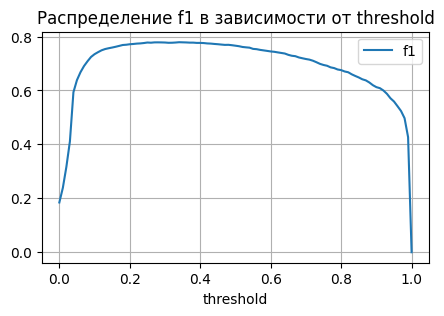

f1_max = 0.7789 при threshold = 0.34


In [108]:
threshold(probability)

In [109]:
best_results_collector(model           = 'CatBoostClassifier', 
                       coding          = 'TF-IDF', 
                       hyperparameters = 'lr = 0.5, depth = 5, iterations = 311 и threshold = 0.34', 
                       f1              = 0.7789)

#### text_features (lem, clear)

Эксперимент на лемматизированном и очищенном тексте, без кодировки.

In [111]:
cb_func(pd.DataFrame(X_train_lem_clear), Y_train,
        pd.DataFrame(X_valid_lem_clear), Y_valid,
        depth=5, learning_rate=0.2, text_features=[0])

0:	learn: 0.4559818	test: 0.4509450	best: 0.4509450 (0)	total: 54.7ms	remaining: 4m 33s
10:	learn: 0.1550047	test: 0.1414473	best: 0.1414473 (10)	total: 605ms	remaining: 4m 34s
20:	learn: 0.1446958	test: 0.1326180	best: 0.1326180 (20)	total: 1.14s	remaining: 4m 31s
30:	learn: 0.1394361	test: 0.1290157	best: 0.1290157 (30)	total: 1.65s	remaining: 4m 24s
40:	learn: 0.1359286	test: 0.1267398	best: 0.1267398 (40)	total: 2.17s	remaining: 4m 22s
50:	learn: 0.1329867	test: 0.1246793	best: 0.1246793 (50)	total: 2.72s	remaining: 4m 23s
60:	learn: 0.1303301	test: 0.1230119	best: 0.1230119 (60)	total: 3.25s	remaining: 4m 23s
70:	learn: 0.1283247	test: 0.1220976	best: 0.1220976 (70)	total: 3.76s	remaining: 4m 21s
80:	learn: 0.1266297	test: 0.1213387	best: 0.1213387 (80)	total: 4.28s	remaining: 4m 19s
90:	learn: 0.1252096	test: 0.1208000	best: 0.1208000 (90)	total: 4.78s	remaining: 4m 18s
100:	learn: 0.1238014	test: 0.1201858	best: 0.1201858 (100)	total: 5.32s	remaining: 4m 17s
110:	learn: 0.122462

0.7729181245626312

**Threshold**

In [112]:
model = CatBoostClassifier(loss_function="Logloss",
                           iterations=5000,
                           learning_rate=0.2,
                           depth=5,
                           early_stopping_rounds=10,
                           text_features = [0])

model.fit(pd.DataFrame(X_train_lem_clear), Y_train, verbose=10, eval_set=(pd.DataFrame(X_valid_lem_clear), Y_valid))
probability = model.predict_proba(pd.DataFrame(X_valid_lem_clear))[:,1]

0:	learn: 0.4559818	test: 0.4509450	best: 0.4509450 (0)	total: 49ms	remaining: 4m 5s
10:	learn: 0.1550047	test: 0.1414473	best: 0.1414473 (10)	total: 602ms	remaining: 4m 32s
20:	learn: 0.1446958	test: 0.1326180	best: 0.1326180 (20)	total: 1.1s	remaining: 4m 20s
30:	learn: 0.1394361	test: 0.1290157	best: 0.1290157 (30)	total: 1.63s	remaining: 4m 20s
40:	learn: 0.1359286	test: 0.1267398	best: 0.1267398 (40)	total: 2.13s	remaining: 4m 17s
50:	learn: 0.1329867	test: 0.1246793	best: 0.1246793 (50)	total: 2.63s	remaining: 4m 15s
60:	learn: 0.1303301	test: 0.1230119	best: 0.1230119 (60)	total: 3.15s	remaining: 4m 15s
70:	learn: 0.1283247	test: 0.1220976	best: 0.1220976 (70)	total: 3.69s	remaining: 4m 16s
80:	learn: 0.1266297	test: 0.1213387	best: 0.1213387 (80)	total: 4.2s	remaining: 4m 15s
90:	learn: 0.1252096	test: 0.1208000	best: 0.1208000 (90)	total: 4.7s	remaining: 4m 13s
100:	learn: 0.1238014	test: 0.1201858	best: 0.1201858 (100)	total: 5.22s	remaining: 4m 13s
110:	learn: 0.1224625	test

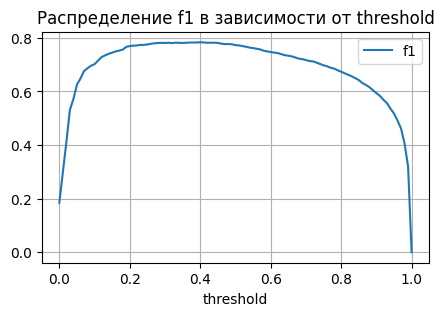

f1_max = 0.7836 при threshold = 0.4


In [113]:
threshold(probability)

In [114]:
best_results_collector(model           = 'CatBoostClassifier', 
                       coding          = 'text_features (lem, clear)', 
                       hyperparameters = 'lr = 0.2, depth = 5, iterations = 239 и threshold = 0.4', 
                       f1              = 0.7836)

#### Bert

In [115]:
%%time
# расчёт f1 в зависимости от глубины дерева
for d in notebook.tqdm(range(1,9)):
    f1 = cb_func(X_train_bert, Y_train, X_valid_bert, Y_valid, depth=d, learning_rate=0.5)

    print(colored(f'f1 = {f1:.4} при depth = {d}\n', 'red', attrs=["bold"]))

  0%|          | 0/8 [00:00<?, ?it/s]

0:	learn: 0.3715639	test: 0.3725578	best: 0.3725578 (0)	total: 36.2ms	remaining: 3m 1s
10:	learn: 0.2286474	test: 0.2283471	best: 0.2283471 (10)	total: 294ms	remaining: 2m 13s
20:	learn: 0.2041329	test: 0.2047141	best: 0.2047141 (20)	total: 571ms	remaining: 2m 15s
30:	learn: 0.1896167	test: 0.1905015	best: 0.1905015 (30)	total: 843ms	remaining: 2m 15s
40:	learn: 0.1814500	test: 0.1826030	best: 0.1826030 (40)	total: 1.1s	remaining: 2m 12s
50:	learn: 0.1751360	test: 0.1765594	best: 0.1765594 (50)	total: 1.35s	remaining: 2m 10s
60:	learn: 0.1705193	test: 0.1724877	best: 0.1724877 (60)	total: 1.6s	remaining: 2m 9s
70:	learn: 0.1667462	test: 0.1694257	best: 0.1694257 (70)	total: 1.85s	remaining: 2m 8s
80:	learn: 0.1636442	test: 0.1667314	best: 0.1667314 (80)	total: 2.1s	remaining: 2m 7s
90:	learn: 0.1611192	test: 0.1645683	best: 0.1645683 (90)	total: 2.35s	remaining: 2m 7s
100:	learn: 0.1589363	test: 0.1627574	best: 0.1627574 (100)	total: 2.61s	remaining: 2m 6s
110:	learn: 0.1567947	test: 0

230:	learn: 0.1268023	test: 0.1468972	best: 0.1468972 (230)	total: 8.37s	remaining: 2m 52s
240:	learn: 0.1257369	test: 0.1466210	best: 0.1465236 (238)	total: 8.69s	remaining: 2m 51s
250:	learn: 0.1246721	test: 0.1463946	best: 0.1462941 (247)	total: 9.03s	remaining: 2m 50s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.1462941072
bestIteration = 247

Shrink model to first 248 iterations.
f1 = 0.691 при depth = 2

0:	learn: 0.3371044	test: 0.3372950	best: 0.3372950 (0)	total: 48.5ms	remaining: 4m 2s
10:	learn: 0.1877879	test: 0.1882970	best: 0.1882970 (10)	total: 540ms	remaining: 4m 4s
20:	learn: 0.1708029	test: 0.1727161	best: 0.1727161 (20)	total: 1.01s	remaining: 4m
30:	learn: 0.1602232	test: 0.1641298	best: 0.1641298 (30)	total: 1.47s	remaining: 3m 56s
40:	learn: 0.1541891	test: 0.1596306	best: 0.1596306 (40)	total: 1.92s	remaining: 3m 52s
50:	learn: 0.1496711	test: 0.1569974	best: 0.1569974 (50)	total: 2.36s	remaining: 3m 49s
60:	learn: 0.1462796	test: 0.1551459

Лучшее f1 = 0.6947 при depth = 1, итерация 659, learning_rate=0.5.

In [116]:
%%time
# расчёт f1 в зависимости от learning_rate
for lr_ in notebook.tqdm((0.1, 1)):
    f1 = cb_func(X_train_bert, Y_train, X_valid_bert, Y_valid, depth=1, learning_rate=lr_)

    print(colored(f'f1 = {f1:.4} при learning_rate = {lr_}\n', 'red', attrs=["bold"]))

  0%|          | 0/2 [00:00<?, ?it/s]

0:	learn: 0.6010057	test: 0.6013790	best: 0.6013790 (0)	total: 25.8ms	remaining: 2m 8s
10:	learn: 0.3032366	test: 0.3030850	best: 0.3030850 (10)	total: 288ms	remaining: 2m 10s
20:	learn: 0.2632728	test: 0.2624090	best: 0.2624090 (20)	total: 548ms	remaining: 2m 10s
30:	learn: 0.2460952	test: 0.2452932	best: 0.2452932 (30)	total: 807ms	remaining: 2m 9s
40:	learn: 0.2340869	test: 0.2333756	best: 0.2333756 (40)	total: 1.06s	remaining: 2m 8s
50:	learn: 0.2247696	test: 0.2242778	best: 0.2242778 (50)	total: 1.31s	remaining: 2m 7s
60:	learn: 0.2174829	test: 0.2170571	best: 0.2170571 (60)	total: 1.56s	remaining: 2m 6s
70:	learn: 0.2114074	test: 0.2109315	best: 0.2109315 (70)	total: 1.81s	remaining: 2m 6s
80:	learn: 0.2064453	test: 0.2060887	best: 0.2060887 (80)	total: 2.07s	remaining: 2m 5s
90:	learn: 0.2021497	test: 0.2018464	best: 0.2018464 (90)	total: 2.32s	remaining: 2m 5s
100:	learn: 0.1978971	test: 0.1977862	best: 0.1977862 (100)	total: 2.57s	remaining: 2m 4s
110:	learn: 0.1946409	test: 0

910:	learn: 0.1437370	test: 0.1497049	best: 0.1497049 (910)	total: 23.5s	remaining: 1m 45s
920:	learn: 0.1435724	test: 0.1496132	best: 0.1496132 (920)	total: 23.8s	remaining: 1m 45s
930:	learn: 0.1434174	test: 0.1494790	best: 0.1494790 (930)	total: 24s	remaining: 1m 45s
940:	learn: 0.1432613	test: 0.1493632	best: 0.1493632 (940)	total: 24.3s	remaining: 1m 44s
950:	learn: 0.1431047	test: 0.1492779	best: 0.1492779 (950)	total: 24.6s	remaining: 1m 44s
960:	learn: 0.1429393	test: 0.1491672	best: 0.1491672 (960)	total: 24.9s	remaining: 1m 44s
970:	learn: 0.1427852	test: 0.1490902	best: 0.1490902 (970)	total: 25.1s	remaining: 1m 44s
980:	learn: 0.1426214	test: 0.1489536	best: 0.1489536 (980)	total: 25.4s	remaining: 1m 44s
990:	learn: 0.1424420	test: 0.1488238	best: 0.1488238 (990)	total: 25.7s	remaining: 1m 44s
1000:	learn: 0.1422908	test: 0.1487215	best: 0.1487215 (1000)	total: 26s	remaining: 1m 43s
1010:	learn: 0.1421448	test: 0.1486414	best: 0.1486414 (1010)	total: 26.2s	remaining: 1m 43s

1800:	learn: 0.1336037	test: 0.1435852	best: 0.1435852 (1800)	total: 47.4s	remaining: 1m 24s
1810:	learn: 0.1335069	test: 0.1435121	best: 0.1435121 (1810)	total: 47.6s	remaining: 1m 23s
1820:	learn: 0.1334341	test: 0.1434712	best: 0.1434712 (1820)	total: 47.9s	remaining: 1m 23s
1830:	learn: 0.1333573	test: 0.1434343	best: 0.1434343 (1830)	total: 48.1s	remaining: 1m 23s
1840:	learn: 0.1332762	test: 0.1433640	best: 0.1433615 (1839)	total: 48.4s	remaining: 1m 23s
1850:	learn: 0.1331920	test: 0.1433294	best: 0.1433294 (1850)	total: 48.7s	remaining: 1m 22s
1860:	learn: 0.1331239	test: 0.1432803	best: 0.1432803 (1860)	total: 48.9s	remaining: 1m 22s
1870:	learn: 0.1330533	test: 0.1432598	best: 0.1432598 (1870)	total: 49.2s	remaining: 1m 22s
1880:	learn: 0.1329695	test: 0.1432178	best: 0.1432116 (1879)	total: 49.4s	remaining: 1m 21s
1890:	learn: 0.1328956	test: 0.1431729	best: 0.1431729 (1890)	total: 49.7s	remaining: 1m 21s
1900:	learn: 0.1328254	test: 0.1431352	best: 0.1431352 (1900)	total: 4

In [117]:
best_results_collector(model           = 'CatBoostClassifier', 
                       coding          = 'Bert', 
                       hyperparameters = ' lr = 0.1, итерация 2380, depth = 1', 
                       f1              = 0.699)

#### Bert(toxic)

In [118]:
%%time
# расчёт f1 в зависимости от глубины дерева
for d in notebook.tqdm(range(1,9)):
    f1 = cb_func(X_train_bert_toxic, Y_train, X_valid_bert_toxic, Y_valid, depth=d, learning_rate=0.5)

    print(colored(f'f1 = {f1:.4} при depth = {d}\n', 'red', attrs=["bold"]))

  0%|          | 0/8 [00:00<?, ?it/s]

0:	learn: 0.1223708	test: 0.1246067	best: 0.1246067 (0)	total: 38.7ms	remaining: 3m 13s
10:	learn: 0.0377116	test: 0.0402436	best: 0.0402436 (10)	total: 301ms	remaining: 2m 16s
20:	learn: 0.0350472	test: 0.0377354	best: 0.0377354 (20)	total: 573ms	remaining: 2m 15s
30:	learn: 0.0333475	test: 0.0363792	best: 0.0363792 (30)	total: 829ms	remaining: 2m 12s
40:	learn: 0.0321232	test: 0.0355797	best: 0.0355096 (38)	total: 1.08s	remaining: 2m 10s
50:	learn: 0.0312189	test: 0.0348286	best: 0.0348286 (50)	total: 1.33s	remaining: 2m 9s
60:	learn: 0.0303833	test: 0.0339082	best: 0.0339082 (60)	total: 1.58s	remaining: 2m 8s
70:	learn: 0.0300343	test: 0.0337234	best: 0.0337234 (70)	total: 1.83s	remaining: 2m 7s
80:	learn: 0.0294460	test: 0.0332294	best: 0.0332221 (79)	total: 2.08s	remaining: 2m 6s
90:	learn: 0.0291355	test: 0.0331907	best: 0.0331607 (89)	total: 2.33s	remaining: 2m 6s
100:	learn: 0.0287550	test: 0.0329689	best: 0.0329689 (100)	total: 2.59s	remaining: 2m 5s
110:	learn: 0.0284368	test

Возможно незначительное улучшение метрики при более долгом и тщательном подборе гиперпараметров; нет необходимости из-за схожего качества на более быстрой LogisticRegression.

In [119]:
best_results_collector(model           = 'CatBoostClassifier', 
                       coding          = 'Bert_toxic', 
                       hyperparameters = 'depth = 7, iterations = 7, lr=0.5', 
                       f1              = 0.9451)

<a id= 'pivot'></a>
### Сводная таблица

In [120]:
best_results.sort_values('f1', ascending=False).reset_index(drop=True)

,model,coding,hyperparameters,f1
0,LogisticRegression,Bert_toxic,"lbfgs, threshold = 0.42",0.9498
1,RandomForestClassifier,Bert_toxic,"n_esimators = 100, depth = max",0.9472
2,CatBoostClassifier,Bert_toxic,"depth = 7, iterations = 7, lr=0.5",0.9451
3,LightGBM,Bert_toxic,"lr = 0.1, iterations = 340, depth=1",0.9444
4,DecisionTreeClassifier,Bert_toxic,depth = 5,0.9383
5,LightGBM,TF-IDF,"lr = 0.1, depth = 5, iterations = 1145 и thres...",0.7909
6,LogisticRegression,TF-IDF,"threshold = 0.67, class_weight = ""balanced""",0.7880
7,CatBoostClassifier,"text_features (lem, clear)","lr = 0.2, depth = 5, iterations = 239 и thresh...",0.7836
8,CatBoostClassifier,TF-IDF,"lr = 0.5, depth = 5, iterations = 311 и thresh...",0.7789
9,LogisticRegression,Bert,"threshold = 0.36, liblinear",0.7426


### Проверка на тестовой выборке

In [132]:
model = LogisticRegression(random_state = constant, max_iter=1000)
model.fit(X_train_bert_toxic, Y_train)
probability = model.predict_proba(X_test_bert_toxic)[:,1]

prediction = (probability>0.42).astype(int)

f1_score(Y_test, prediction).round(4)

0.9431

## Выводы

* Исходный датасет состоит из размеченного набора комментариев - 152292 шт.
* Сильный дисбаланс: нетоксичных твитов в 10 раз больше чем токсичных. Дубликатов нет.
* Проверено 3 варианта кодирования: TF-IDF (после лемматизации и очистки от стоп-слов), Bert и Bert_toxic.
* Протестировано 5 типов ML-алгоритмов (LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, LightGBM, CatBoostClassifier). См. сводную таблицу в [п.3.6](#pivot).
* Значительно лучшие результаты показали модели закодированные на предобученном алгоритме Bert_toxic, что говорит о важности правильного выбора предобученной модели Bert в задачах NLP.
* Лучшая модель  LogisticRegression (Bert_toxic) c алгоритмом оптимизации lbfgs на тестовой выборке дала результат F1 = 0.9431. <br> Кроме того данная линейная модель является самой быстрой, что важно для комфортного пользования сайтом магазина.